In [431]:
# import modules
import warnings
warnings.filterwarnings('ignore')

import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
import optuna
from optuna.samplers import TPESampler

from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, minmax_scale
from sklearn.metrics import confusion_matrix, log_loss, f1_score

import random
from math import floor
from scipy.stats import mode, scoreatpercentile

print("Seaborn version : ", sns.__version__)
sns.set()
#sns.set_style('whitegrid')
sns.set_color_codes()
sns.set_theme(style="ticks", palette="pastel")



# upload data
train = pd.read_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/train.csv',index_col=0)
test = pd.read_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/test.csv',index_col=0)
submit = pd.read_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/sample_submission.csv')

Seaborn version :  0.11.1


In [432]:
# defs
def show_4digits(x) : 
    return str(x)[:3]

In [433]:
# outliers
train.drop((train[train['child_num']>=6]).index, inplace = True)

In [434]:
for df in [train, test] : 
    # no information
    df.drop('FLAG_MOBIL',axis = 1, inplace = True)

    # negative to positive
    df['DAYS_BIRTH'] = -df['DAYS_BIRTH']
    df['DAYS_EMPLOYED'] = -df['DAYS_EMPLOYED']
    df['begin_month'] = -df['begin_month']

    # handling the missing values
    ## occyp_type == NaN
    df['occyp_type'] = df.occyp_type.fillna('missing')
    df.loc[(df.DAYS_EMPLOYED == -365243)&(df.occyp_type.isna()), 'occyp_type'] = 'in_occyp'
    ## DAYS_EMPLOYED == 365243
    df['DAYS_EMPLOYED'][df['DAYS_EMPLOYED'] == -365243] = 0

In [435]:
for df in [train, test] : 
    # personal_id
    df['personal_id']= \
    df['gender']+\
    df['car']+\
    df['income_total'].apply(lambda x: str(int(x)).zfill(7))+\
    df['edu_type'].apply(show_4digits)+\
    df['family_type'].apply(show_4digits)+\
    df['house_type'].apply(show_4digits)+\
    df['DAYS_BIRTH'].apply(lambda x: str(x).zfill(5))+\
    df['DAYS_EMPLOYED'].apply(lambda x: str(x).zfill(5))+\
    df['occyp_type'].apply(show_4digits)

    # 재산, 연락처에 관한 정보들을 묶어서 분류
    df['group_property'] = df['car'].astype(str)   + df['reality'].astype(str)
    df['group_contacts'] = df['phone'].astype(str) + df['work_phone'].astype(str) + df['email'].astype(str)
    df['group_whoare_u'] = df['gender'].astype(str)+ df['family_type'].astype(str)

In [436]:
for df in [train, test] : 
    # 현재 하고 있는 일을 시작하게 된 나이(날짜) = 일을 하지 않았던 기간 
    df['DAYS_nowork'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']

    # 가족 수와 관련된 변수
    df['adult_num'] = df['family_size'] - df['child_num']
    df.loc[df.child_num >= 5, 'child_num'] = 5
    df.loc[df.child_num >= 5, 'family_size'] = df.loc[df.child_num >= 5, 'child_num'] + df.loc[df.child_num >= 5, 'adult_num']

    # 소득과 관련된 변수와 조합
    df['income_per_child'] = df['income_total']/ df['child_num']  #소득을 아이 수로 나눠 각 아이에게 할당 될 수 있는 금액을 계산 
    df['income_per_family']= df['income_total']/ df['family_size']#소득을 가족 수로 나눠 각 인원에게 할당 될 수 있는 금액을 계산
    df['income_per_age']   = df['income_total']/ df['DAYS_BIRTH'] #소득을 나이로 나눠 나이 대비 얼마나 버는지에 대한 지표 생성

    # 로그 변환(income_total)
    df['income_total_log'] = np.log(df['income_total']+1)

    # 날짜표기 변환(begin_month) : 4로 나누어 계절로 분할
    df['begin_season'] = df['begin_month'].apply(lambda x: floor(x/4))

    # 날짜표기 변환(DAYS_EMPLOYED) : 개월로 binning
    df['mm_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: floor(x/30.4375))

    # 날쨔 표기 변환(DAYS_EMPLOYED): 연차로 binning
    df['yy_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: floor(x/365.25))



In [437]:
personal_info = train.drop(['credit', 'begin_month'], axis = 1).drop_duplicates(subset='personal_id', keep='first', inplace=False, ignore_index=True)

F, F_birth_labels = pd.qcut(personal_info.DAYS_BIRTH[personal_info.gender == 'F'], q = 20, retbins=True)
M, M_birth_labels = pd.qcut(personal_info.DAYS_BIRTH[personal_info.gender == 'M'], q = 20, retbins=True)
F_birth_labels.put(0, F_birth_labels[0]-.001)
M_birth_labels.put(0, M_birth_labels[0]-.001)


personal_info['age_F_bins'] = F
personal_info['n_F_age'] = personal_info.groupby('age_F_bins').gender.count()
personal_info['age_M_bins'] = M
personal_info['n_M_age'] = personal_info.groupby('age_M_bins').gender.count()

personal_info['income_mean_F_age']  = personal_info.groupby([pd.cut(personal_info.DAYS_BIRTH, bins = F_birth_labels), 'gender']).income_total.transform(np.mean)
personal_info['income_mean_M_age']  = personal_info.groupby([pd.cut(personal_info.DAYS_BIRTH, bins = M_birth_labels), 'gender']).income_total.transform(np.mean)
personal_info['income_std_F_age']   = personal_info.groupby([pd.cut(personal_info.DAYS_BIRTH, bins = F_birth_labels), 'gender']).income_total.transform(np.std)
personal_info['income_std_M_age']   = personal_info.groupby([pd.cut(personal_info.DAYS_BIRTH, bins = M_birth_labels), 'gender']).income_total.transform(np.std)

personal_info['employed_mean_F_age']= personal_info.groupby([pd.cut(personal_info.DAYS_BIRTH, bins = F_birth_labels), 'gender']).DAYS_EMPLOYED.transform(np.mean)
personal_info['employed_mean_M_age']= personal_info.groupby([pd.cut(personal_info.DAYS_BIRTH, bins = M_birth_labels), 'gender']).DAYS_EMPLOYED.transform(np.mean)
personal_info['employed_std_F_age'] = personal_info.groupby([pd.cut(personal_info.DAYS_BIRTH, bins = F_birth_labels), 'gender']).DAYS_EMPLOYED.transform(np.std)
personal_info['employed_std_M_age'] = personal_info.groupby([pd.cut(personal_info.DAYS_BIRTH, bins = M_birth_labels), 'gender']).DAYS_EMPLOYED.transform(np.std)

F_age_info = personal_info.groupby('age_F_bins')[['income_mean_F_age', 'income_std_F_age', 'employed_mean_F_age', 'employed_std_F_age', 'n_F_age']].apply(np.mean)
M_age_info = personal_info.groupby('age_M_bins')[['income_mean_M_age', 'income_std_M_age', 'employed_mean_M_age', 'employed_std_M_age', 'n_M_age']].apply(np.mean)



In [438]:
pre_ = test.DAYS_BIRTH.iloc[6031]
test.DAYS_BIRTH.iloc[6031] = 7757

for df in [train, test]:
    df['age_F_bins'] = pd.cut(df.DAYS_BIRTH, bins = F_birth_labels)
    df['age_M_bins'] = pd.cut(df.DAYS_BIRTH, bins = M_birth_labels)

#예외 발생(test)
test.DAYS_BIRTH.iloc[6031] = pre_

train = pd.merge(train, F_age_info, how = 'left', on = 'age_F_bins')
train = pd.merge(train, M_age_info, how = 'left', on = 'age_M_bins')
test = pd.merge(test, F_age_info, how = 'left', on = 'age_F_bins')
test = pd.merge(test, M_age_info, how = 'left', on = 'age_M_bins')

for df in [train, test]:
    df['ability_income_per_age_by_gen'] = 0
    df['ability_income_per_age_by_gen'][df.gender == 'F'] = ((df['income_total'] - df['income_mean_F_age'])/(df['income_std_F_age']/df['n_F_age'].apply(np.sqrt)))[df.gender == 'F']
    df['ability_income_per_age_by_gen'][df.gender == 'M'] = ((df['income_total'] - df['income_mean_M_age'])/(df['income_std_M_age']/df['n_M_age'].apply(np.sqrt)))[df.gender == 'M']
    df['ability_emp_per_age_by_gen'] = 0
    df['ability_emp_per_age_by_gen'][df.gender == 'F'] = ((df['DAYS_EMPLOYED'] - df['employed_mean_F_age'])/(df['employed_std_F_age']/df['n_F_age'].apply(np.sqrt)))[df.gender == 'F']
    df['ability_emp_per_age_by_gen'][df.gender == 'M'] = ((df['DAYS_EMPLOYED'] - df['employed_mean_M_age'])/(df['employed_std_M_age']/df['n_M_age'].apply(np.sqrt)))[df.gender == 'M']
    

In [439]:
drop_list = [#'income_total', 
             'age_F_bins', 'age_M_bins', 
             'income_mean_F_age', 'income_std_F_age', 'employed_mean_F_age', 'employed_std_F_age', 'n_F_age',
             'income_mean_M_age', 'income_std_M_age', 'employed_mean_M_age', 'employed_std_M_age', 'n_M_age', 
            ]

for df in [train, test]:
    df.drop(drop_list, axis = 1, inplace = True)

In [440]:
one_child_fee = (personal_info.income_total/personal_info.family_size)[(personal_info.DAYS_BIRTH > 33*365) & (personal_info.DAYS_BIRTH < 37*365) & (personal_info.child_num == 1)].mean()



In [70]:
# 부모의 학력이 올라갈 수록 자녀에 투자하는 금액이 많을것이다.
# 버는 만큼? => 소득 수준
# 아이의 수 만큼?
# 부모의 나이 만큼?

# 부모의 학력에 대한 가중치 * 아이의 수 가중치 * 부모의 나이 가중치* 부모의 소득 가중치
# merge형태(모수가 있다.)
#personal_info['weight_edu'] = personal_info.groupby('edu_type').income_total.transform(np.mean)
# 함수 형태(모수는 없음.) => 데이터에 직접 적용
#personal_info['weight_chd'] = personal_info['child_num'].transform(lambda x: np.log(1+x)/np.log(2))
#personal_info['weight_age'] = personal_info['']

In [441]:
df_weight_edu = personal_info.groupby('edu_type').income_total.apply(np.mean)#.reset_index()
df_weight_edu.name = 'weight_edu'
df_weight_edu = df_weight_edu.reset_index()

In [442]:
from scipy.stats import norm

In [443]:
# car fee
def car_weight(x, loc_par_car):
    _max = personal_info.income_total.max()
    _med = loc_par_car
    if x < _med : 
        return 1
    else:
        return 1+(x-_med)/(_max-_med)*5



In [449]:
train_money.car

0        N
1        N
2        Y
3        N
4        Y
        ..
26446    N
26447    N
26448    Y
26449    N
26450    N
Name: car, Length: 26451, dtype: object

In [452]:
n_fold = 5
n_class = 3

def objective(trial):
            
    d_age_std = trial.suggest_float("d_age_std", 5, 8)
    d_age_mu = trial.suggest_float("d_age_mu", 34, 36)
    weight_c = trial.suggest_float("weight_c", 1.3, 1.7)
    weight_b = trial.suggest_float("weight_b", 0.1, 2)
    loc_par_car = trial.suggest_int("loc_par_car", 127500.0, 187500.0)

    train_money = pd.merge(train, df_weight_edu, how = 'left', on = 'edu_type') # 'weight_edu'
    train_money['weight_chd'] = train_money['child_num'].transform(lambda x: np.log(1+x)/np.log(2))
    train_money['weight_age'] = train_money['DAYS_BIRTH'].transform(lambda x: norm(d_age_mu, scale = d_age_std).pdf((x/365.25))/norm(d_age_mu, scale = d_age_std).pdf(d_age_mu))
    train_money['child_fee_total'] = one_child_fee*train_money['weight_edu']*train_money['weight_chd']*train_money['weight_age']
    train_money['car_fees_total'] = train_money.income_total.median()*0.1*(train_money.car == 'Y').astype('int')*train_money.income_total.apply(lambda x: car_weight(x, loc_par_car))
    train_money['save_income'] = train_money['income_total'] - weight_c*train_money['child_fee_total'] - weight_b*train_money['car_fees_total']
    train_money.drop(['weight_edu', 'weight_chd', 'weight_age', 'child_fee_total', 'car_fees_total'], axis = 1, inplace = True)
    
    numerical_feats = train_money.dtypes[train_money.dtypes != "object"].index.tolist()
    categorical_feats = train_money.dtypes[train_money.dtypes == "object"].index.tolist()
    
    target = 'credit'
    X_money = train_money.drop(target, axis=1)
    y_money = train_money[target]

    cat_pred = np.zeros((X_money.shape[0], n_class))
    cat_cols = categorical_feats
    
    skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=55)
    folds=[]
    for train_idx, valid_idx in skfold.split(X_money, y_money):
            folds.append((train_idx, valid_idx))


    # 5Fold-CV (StratifiedKFold)
    for fold in range(len(folds)):
        print(f'\n----------------- Fold {fold+1} -----------------\n')
        train_idx, valid_idx = folds[fold]
        X_train, X_valid, y_train, y_valid = X_money.iloc[train_idx], X_money.iloc[valid_idx], y_money.iloc[train_idx], y_money.iloc[valid_idx]
        train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
        valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

        model_cat = CatBoostClassifier(max_depth=8, random_seed=42,
                                       learning_rate=0.1, 
                                       bootstrap_type ='Bernoulli',
                                       used_ram_limit ="8gb",
                                      )
        model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=50, verbose=100)

        cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
        print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')

    print(f'\tLog Loss: {log_loss(y_money, cat_pred):.6f}')
    return log_loss(y_money, cat_pred)

In [453]:
money_weight_study = optuna.create_study(direction="minimize")
money_weight_study.optimize(objective, n_trials=50)

[I 2021-06-19 22:00:31,994] A new study created in memory with name: no-name-479c902f-9fd3-4b03-b7f6-90691334b960



----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 15.3ms	remaining: 15.3s
100:	learn: 0.6961838	test: 0.6777607	best: 0.6777491 (99)	total: 4.24s	remaining: 37.8s
200:	learn: 0.6561606	test: 0.6724926	best: 0.6724041 (198)	total: 9.23s	remaining: 36.7s
300:	learn: 0.6173495	test: 0.6720756	best: 0.6714871 (285)	total: 14.8s	remaining: 34.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6714871493
bestIteration = 285

Shrink model to first 286 iterations.
CV Log Loss Score: 0.671487

----------------- Fold 2 -----------------

0:	learn: 1.0429140	test: 1.0431616	best: 1.0431616 (0)	total: 37.3ms	remaining: 37.3s
100:	learn: 0.6973563	test: 0.6714851	best: 0.6714851 (100)	total: 4.28s	remaining: 38.1s
200:	learn: 0.6621481	test: 0.6697619	best: 0.6694670 (152)	total: 9.84s	remaining: 39.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6694669505
bestIteration = 152

Shrink model to first

[I 2021-06-19 22:03:43,593] Trial 0 finished with value: 0.6662114575473512 and parameters: {'d_age_std': 6.894984844693635, 'd_age_mu': 35.34994118762474, 'weight_c': 1.5906297429702407, 'weight_b': 0.8256965264738497, 'loc_par_car': 171224}. Best is trial 0 with value: 0.6662114575473512.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6693518856
bestIteration = 293

Shrink model to first 294 iterations.
CV Log Loss Score: 0.669352
	Log Loss: 0.666211

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 13.6ms	remaining: 13.6s
100:	learn: 0.6943251	test: 0.6764220	best: 0.6764220 (100)	total: 4.31s	remaining: 38.4s
200:	learn: 0.6580805	test: 0.6728678	best: 0.6727102 (197)	total: 9.49s	remaining: 37.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6726111697
bestIteration = 246

Shrink model to first 247 iterations.
CV Log Loss Score: 0.672611

----------------- Fold 2 -----------------

0:	learn: 1.0428930	test: 1.0431760	best: 1.0431760 (0)	total: 38.9ms	remaining: 38.9s
100:	learn: 0.6969073	test: 0.6712249	best: 0.6710875 (97)	total: 4.62s	remaining: 41.1s
200:	learn: 0.6617470	test: 0.6688796	best: 0.6686388 (194)	total: 10.5s	remaining: 41.8s
Stopped by overfitting de

[I 2021-06-19 22:06:58,215] Trial 1 finished with value: 0.6661353456132341 and parameters: {'d_age_std': 7.748407359896198, 'd_age_mu': 34.07878315402039, 'weight_c': 1.5639904334504728, 'weight_b': 1.792813365377898, 'loc_par_car': 146128}. Best is trial 1 with value: 0.6661353456132341.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6695861861
bestIteration = 192

Shrink model to first 193 iterations.
CV Log Loss Score: 0.669586
	Log Loss: 0.666135

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 14ms	remaining: 14s
100:	learn: 0.6927981	test: 0.6772895	best: 0.6772682 (99)	total: 4.28s	remaining: 38.1s
200:	learn: 0.6563139	test: 0.6743615	best: 0.6740225 (173)	total: 9.11s	remaining: 36.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.674022514
bestIteration = 173

Shrink model to first 174 iterations.
CV Log Loss Score: 0.674023

----------------- Fold 2 -----------------

0:	learn: 1.0428982	test: 1.0431954	best: 1.0431954 (0)	total: 39.8ms	remaining: 39.8s
100:	learn: 0.6965623	test: 0.6711531	best: 0.6709874 (99)	total: 4.51s	remaining: 40.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6695798812
bestIteration = 139

Shrink model to first

[I 2021-06-19 22:09:50,560] Trial 2 finished with value: 0.6668544359107861 and parameters: {'d_age_std': 7.075996824647775, 'd_age_mu': 34.45154636462815, 'weight_c': 1.5724855762417136, 'weight_b': 0.8821816611283809, 'loc_par_car': 176809}. Best is trial 1 with value: 0.6661353456132341.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.669785589
bestIteration = 194

Shrink model to first 195 iterations.
CV Log Loss Score: 0.669786
	Log Loss: 0.666854

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 15.7ms	remaining: 15.7s
100:	learn: 0.6947129	test: 0.6788803	best: 0.6782655 (97)	total: 4.16s	remaining: 37s
200:	learn: 0.6571542	test: 0.6747790	best: 0.6745884 (171)	total: 9.22s	remaining: 36.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6745883611
bestIteration = 171

Shrink model to first 172 iterations.
CV Log Loss Score: 0.674588

----------------- Fold 2 -----------------

0:	learn: 1.0429162	test: 1.0432321	best: 1.0432321 (0)	total: 41.9ms	remaining: 41.9s
100:	learn: 0.6968612	test: 0.6710702	best: 0.6710702 (100)	total: 4.37s	remaining: 38.9s
200:	learn: 0.6605854	test: 0.6688429	best: 0.6685817 (191)	total: 9.61s	remaining: 38.2s
Stopped by overfitting detec

[I 2021-06-19 22:12:26,527] Trial 3 finished with value: 0.6667699082961513 and parameters: {'d_age_std': 6.191340214907488, 'd_age_mu': 34.158575266512656, 'weight_c': 1.6034557896732344, 'weight_b': 0.9026322040081834, 'loc_par_car': 150125}. Best is trial 1 with value: 0.6661353456132341.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6718415302
bestIteration = 142

Shrink model to first 143 iterations.
CV Log Loss Score: 0.671842
	Log Loss: 0.666770

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 14ms	remaining: 13.9s
100:	learn: 0.6956832	test: 0.6761613	best: 0.6761613 (100)	total: 4.04s	remaining: 36s
200:	learn: 0.6600385	test: 0.6725958	best: 0.6721692 (172)	total: 9.1s	remaining: 36.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6721691646
bestIteration = 172

Shrink model to first 173 iterations.
CV Log Loss Score: 0.672169

----------------- Fold 2 -----------------

0:	learn: 1.0429033	test: 1.0431807	best: 1.0431807 (0)	total: 37.5ms	remaining: 37.5s
100:	learn: 0.6970887	test: 0.6710849	best: 0.6710790 (97)	total: 4.4s	remaining: 39.1s
200:	learn: 0.6589431	test: 0.6693437	best: 0.6692703 (196)	total: 9.69s	remaining: 38.5s
300:	learn: 0.6222065	test: 0.6

[I 2021-06-19 22:15:24,374] Trial 4 finished with value: 0.6663755701571271 and parameters: {'d_age_std': 6.954864342159008, 'd_age_mu': 34.15761914445323, 'weight_c': 1.4439704915060267, 'weight_b': 1.2167620530021748, 'loc_par_car': 150729}. Best is trial 1 with value: 0.6661353456132341.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6694373783
bestIteration = 206

Shrink model to first 207 iterations.
CV Log Loss Score: 0.669437
	Log Loss: 0.666376

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 14.2ms	remaining: 14.1s
100:	learn: 0.6944030	test: 0.6773965	best: 0.6773965 (100)	total: 4.26s	remaining: 37.9s
200:	learn: 0.6564845	test: 0.6739020	best: 0.6738130 (157)	total: 9.23s	remaining: 36.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6734480718
bestIteration = 229

Shrink model to first 230 iterations.
CV Log Loss Score: 0.673448

----------------- Fold 2 -----------------

0:	learn: 1.0429123	test: 1.0431612	best: 1.0431612 (0)	total: 39ms	remaining: 39s
100:	learn: 0.6939700	test: 0.6712198	best: 0.6712198 (100)	total: 4.33s	remaining: 38.5s
200:	learn: 0.6604576	test: 0.6694175	best: 0.6690834 (182)	total: 9.63s	remaining: 38.3s
Stopped by overfitting detec

[I 2021-06-19 22:18:24,915] Trial 5 finished with value: 0.6660947575715305 and parameters: {'d_age_std': 7.0273994333537075, 'd_age_mu': 35.01097426926515, 'weight_c': 1.5136662054307513, 'weight_b': 0.855360985799734, 'loc_par_car': 157225}. Best is trial 5 with value: 0.6660947575715305.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6689695632
bestIteration = 238

Shrink model to first 239 iterations.
CV Log Loss Score: 0.668970
	Log Loss: 0.666095

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 15.3ms	remaining: 15.3s
100:	learn: 0.6961838	test: 0.6777767	best: 0.6777652 (99)	total: 4.29s	remaining: 38.2s
200:	learn: 0.6602351	test: 0.6758172	best: 0.6747337 (169)	total: 9.37s	remaining: 37.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6747337011
bestIteration = 169

Shrink model to first 170 iterations.
CV Log Loss Score: 0.674734

----------------- Fold 2 -----------------

0:	learn: 1.0429164	test: 1.0431619	best: 1.0431619 (0)	total: 41.5ms	remaining: 41.5s
100:	learn: 0.6982350	test: 0.6710943	best: 0.6710943 (100)	total: 4.41s	remaining: 39.2s
200:	learn: 0.6623735	test: 0.6691304	best: 0.6687796 (183)	total: 9.76s	remaining: 38.8s
Stopped by overfitting de

[I 2021-06-19 22:21:24,145] Trial 6 finished with value: 0.6664265568433457 and parameters: {'d_age_std': 7.9355534094483495, 'd_age_mu': 35.26951018148062, 'weight_c': 1.517506646645677, 'weight_b': 0.6580909119790289, 'loc_par_car': 185437}. Best is trial 5 with value: 0.6660947575715305.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.669836321
bestIteration = 182

Shrink model to first 183 iterations.
CV Log Loss Score: 0.669836
	Log Loss: 0.666427

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 14.3ms	remaining: 14.3s
100:	learn: 0.6947552	test: 0.6767454	best: 0.6767454 (100)	total: 4.28s	remaining: 38.1s
200:	learn: 0.6582433	test: 0.6738176	best: 0.6738176 (200)	total: 9.34s	remaining: 37.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6735605272
bestIteration = 210

Shrink model to first 211 iterations.
CV Log Loss Score: 0.673561

----------------- Fold 2 -----------------

0:	learn: 1.0429111	test: 1.0431782	best: 1.0431782 (0)	total: 40.7ms	remaining: 40.6s
100:	learn: 0.6937987	test: 0.6711204	best: 0.6711204 (100)	total: 4.4s	remaining: 39.2s
200:	learn: 0.6583153	test: 0.6701429	best: 0.6700031 (186)	total: 9.65s	remaining: 38.4s
300:	learn: 0.6198931	test

[I 2021-06-19 22:24:19,799] Trial 7 finished with value: 0.6665174959870733 and parameters: {'d_age_std': 7.573476741834542, 'd_age_mu': 35.05462533802956, 'weight_c': 1.5027915163365588, 'weight_b': 1.6534817065890328, 'loc_par_car': 165569}. Best is trial 5 with value: 0.6660947575715305.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6714032081
bestIteration = 192

Shrink model to first 193 iterations.
CV Log Loss Score: 0.671403
	Log Loss: 0.666517

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 14.2ms	remaining: 14.1s
100:	learn: 0.6943669	test: 0.6768663	best: 0.6768663 (100)	total: 4.12s	remaining: 36.7s
200:	learn: 0.6579614	test: 0.6743404	best: 0.6736314 (170)	total: 9.09s	remaining: 36.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6736313899
bestIteration = 170

Shrink model to first 171 iterations.
CV Log Loss Score: 0.673631

----------------- Fold 2 -----------------

0:	learn: 1.0428971	test: 1.0431849	best: 1.0431849 (0)	total: 39.9ms	remaining: 39.8s
100:	learn: 0.6972928	test: 0.6706089	best: 0.6704777 (98)	total: 4.28s	remaining: 38.1s
200:	learn: 0.6624960	test: 0.6690201	best: 0.6686798 (174)	total: 9.43s	remaining: 37.5s
Stopped by overfitting de

[I 2021-06-19 22:27:12,649] Trial 8 finished with value: 0.6660219407755484 and parameters: {'d_age_std': 6.337879075116563, 'd_age_mu': 35.56804210466584, 'weight_c': 1.5913204119968496, 'weight_b': 1.7737264794342327, 'loc_par_car': 167850}. Best is trial 8 with value: 0.6660219407755484.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6699381523
bestIteration = 170

Shrink model to first 171 iterations.
CV Log Loss Score: 0.669938
	Log Loss: 0.666022

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 14.3ms	remaining: 14.3s
100:	learn: 0.6965104	test: 0.6773711	best: 0.6773204 (99)	total: 4.25s	remaining: 37.8s
200:	learn: 0.6589489	test: 0.6752744	best: 0.6745251 (175)	total: 9.24s	remaining: 36.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6745250503
bestIteration = 175

Shrink model to first 176 iterations.
CV Log Loss Score: 0.674525

----------------- Fold 2 -----------------

0:	learn: 1.0429069	test: 1.0431658	best: 1.0431658 (0)	total: 40.5ms	remaining: 40.5s
100:	learn: 0.6988290	test: 0.6719650	best: 0.6719091 (99)	total: 4.41s	remaining: 39.2s
200:	learn: 0.6626737	test: 0.6696138	best: 0.6693212 (190)	total: 9.71s	remaining: 38.6s
Stopped by overfitting det

[I 2021-06-19 22:30:01,702] Trial 9 finished with value: 0.6668161109327299 and parameters: {'d_age_std': 5.204017585445289, 'd_age_mu': 35.52409603308876, 'weight_c': 1.4570902696015484, 'weight_b': 1.9319633192398462, 'loc_par_car': 142046}. Best is trial 8 with value: 0.6660219407755484.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6714650982
bestIteration = 191

Shrink model to first 192 iterations.
CV Log Loss Score: 0.671465
	Log Loss: 0.666816

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 14.5ms	remaining: 14.5s
100:	learn: 0.6961580	test: 0.6777690	best: 0.6777576 (99)	total: 4.27s	remaining: 38s
200:	learn: 0.6556674	test: 0.6746010	best: 0.6743441 (195)	total: 9.13s	remaining: 36.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6743440687
bestIteration = 195

Shrink model to first 196 iterations.
CV Log Loss Score: 0.674344

----------------- Fold 2 -----------------

0:	learn: 1.0428916	test: 1.0431876	best: 1.0431876 (0)	total: 41.1ms	remaining: 41.1s
100:	learn: 0.6959852	test: 0.6704354	best: 0.6704354 (100)	total: 4.49s	remaining: 40s
200:	learn: 0.6586743	test: 0.6691759	best: 0.6684634 (161)	total: 9.7s	remaining: 38.5s
Stopped by overfitting detecto

[I 2021-06-19 22:32:51,618] Trial 10 finished with value: 0.6668352051808528 and parameters: {'d_age_std': 5.870476089544651, 'd_age_mu': 35.97434025254882, 'weight_c': 1.6936082987824483, 'weight_b': 0.22941962981217778, 'loc_par_car': 128142}. Best is trial 8 with value: 0.6660219407755484.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6690504701
bestIteration = 214

Shrink model to first 215 iterations.
CV Log Loss Score: 0.669050
	Log Loss: 0.666835

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 14.9ms	remaining: 14.9s
100:	learn: 0.6947624	test: 0.6763916	best: 0.6763499 (99)	total: 4.13s	remaining: 36.8s
200:	learn: 0.6591073	test: 0.6743648	best: 0.6739128 (162)	total: 9.1s	remaining: 36.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6739128161
bestIteration = 162

Shrink model to first 163 iterations.
CV Log Loss Score: 0.673913

----------------- Fold 2 -----------------

0:	learn: 1.0428920	test: 1.0431776	best: 1.0431776 (0)	total: 41.1ms	remaining: 41s
100:	learn: 0.6959502	test: 0.6707484	best: 0.6707484 (100)	total: 4.54s	remaining: 40.4s
200:	learn: 0.6598784	test: 0.6680560	best: 0.6678566 (191)	total: 9.75s	remaining: 38.8s
300:	learn: 0.6238341	test: 

[I 2021-06-19 22:35:51,599] Trial 11 finished with value: 0.6665600589489012 and parameters: {'d_age_std': 5.7616130150819655, 'd_age_mu': 35.90528525483941, 'weight_c': 1.3247694134375, 'weight_b': 1.3010575907469926, 'loc_par_car': 160799}. Best is trial 8 with value: 0.6660219407755484.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6705744042
bestIteration = 290

Shrink model to first 291 iterations.
CV Log Loss Score: 0.670574
	Log Loss: 0.666560

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 14.4ms	remaining: 14.4s
100:	learn: 0.6961805	test: 0.6777623	best: 0.6777508 (99)	total: 4.2s	remaining: 37.4s
200:	learn: 0.6555336	test: 0.6756382	best: 0.6748675 (180)	total: 9.27s	remaining: 36.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6748675348
bestIteration = 180

Shrink model to first 181 iterations.
CV Log Loss Score: 0.674868

----------------- Fold 2 -----------------

0:	learn: 1.0429163	test: 1.0431833	best: 1.0431833 (0)	total: 41.6ms	remaining: 41.6s
100:	learn: 0.6953411	test: 0.6718423	best: 0.6715205 (97)	total: 4.37s	remaining: 38.9s
200:	learn: 0.6587393	test: 0.6694728	best: 0.6694083 (197)	total: 9.67s	remaining: 38.5s
Stopped by overfitting dete

[I 2021-06-19 22:38:53,711] Trial 12 finished with value: 0.6668387628278932 and parameters: {'d_age_std': 6.499965103559166, 'd_age_mu': 34.68838564933123, 'weight_c': 1.6709113778499693, 'weight_b': 0.21272301347503408, 'loc_par_car': 175147}. Best is trial 8 with value: 0.6660219407755484.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6693552215
bestIteration = 268

Shrink model to first 269 iterations.
CV Log Loss Score: 0.669355
	Log Loss: 0.666839

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 14.5ms	remaining: 14.5s
100:	learn: 0.6961648	test: 0.6777742	best: 0.6777627 (99)	total: 4.21s	remaining: 37.5s
200:	learn: 0.6562500	test: 0.6753066	best: 0.6747555 (182)	total: 9.14s	remaining: 36.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.674467691
bestIteration = 238

Shrink model to first 239 iterations.
CV Log Loss Score: 0.674468

----------------- Fold 2 -----------------

0:	learn: 1.0428981	test: 1.0431592	best: 1.0431592 (0)	total: 40.6ms	remaining: 40.5s
100:	learn: 0.6957816	test: 0.6717354	best: 0.6717354 (100)	total: 4.46s	remaining: 39.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6688986047
bestIteration = 126

Shrink model to 

[I 2021-06-19 22:41:41,274] Trial 13 finished with value: 0.666992974992434 and parameters: {'d_age_std': 7.332282456048757, 'd_age_mu': 35.69994011414679, 'weight_c': 1.4140775332203888, 'weight_b': 0.5122546001622683, 'loc_par_car': 158442}. Best is trial 8 with value: 0.6660219407755484.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.671496639
bestIteration = 168

Shrink model to first 169 iterations.
CV Log Loss Score: 0.671497
	Log Loss: 0.666993

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 15.6ms	remaining: 15.6s
100:	learn: 0.6954941	test: 0.6763838	best: 0.6763150 (99)	total: 4.05s	remaining: 36.1s
200:	learn: 0.6576427	test: 0.6731697	best: 0.6731697 (200)	total: 8.95s	remaining: 35.6s
300:	learn: 0.6216623	test: 0.6720275	best: 0.6717159 (287)	total: 14.3s	remaining: 33.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6717159359
bestIteration = 287

Shrink model to first 288 iterations.
CV Log Loss Score: 0.671716

----------------- Fold 2 -----------------

0:	learn: 1.0429134	test: 1.0431619	best: 1.0431619 (0)	total: 37.9ms	remaining: 37.9s
100:	learn: 0.6979662	test: 0.6709565	best: 0.6709565 (100)	total: 4.31s	remaining: 38.4s
200:	learn: 0.6596423	test

[I 2021-06-19 22:44:37,725] Trial 14 finished with value: 0.6662761860064771 and parameters: {'d_age_std': 6.500197937052375, 'd_age_mu': 34.85977220375211, 'weight_c': 1.6430803563742598, 'weight_b': 1.460296771925592, 'loc_par_car': 187291}. Best is trial 8 with value: 0.6660219407755484.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6694146304
bestIteration = 184

Shrink model to first 185 iterations.
CV Log Loss Score: 0.669415
	Log Loss: 0.666276

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 13.4ms	remaining: 13.4s
100:	learn: 0.6961558	test: 0.6777590	best: 0.6777476 (99)	total: 4.21s	remaining: 37.5s
200:	learn: 0.6564035	test: 0.6743363	best: 0.6743363 (200)	total: 9.15s	remaining: 36.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6737999643
bestIteration = 221

Shrink model to first 222 iterations.
CV Log Loss Score: 0.673800

----------------- Fold 2 -----------------

0:	learn: 1.0429011	test: 1.0431507	best: 1.0431507 (0)	total: 39.6ms	remaining: 39.6s
100:	learn: 0.6942199	test: 0.6711864	best: 0.6711864 (100)	total: 4.39s	remaining: 39.1s
200:	learn: 0.6568893	test: 0.6683447	best: 0.6683447 (200)	total: 9.61s	remaining: 38.2s
Stopped by overfitting de

[I 2021-06-19 22:47:29,742] Trial 15 finished with value: 0.6673316862268311 and parameters: {'d_age_std': 6.517060651228914, 'd_age_mu': 35.21080075746799, 'weight_c': 1.3705084164348835, 'weight_b': 1.1613169885895473, 'loc_par_car': 134182}. Best is trial 8 with value: 0.6660219407755484.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6721309188
bestIteration = 213

Shrink model to first 214 iterations.
CV Log Loss Score: 0.672131
	Log Loss: 0.667332

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 13.6ms	remaining: 13.6s
100:	learn: 0.6950582	test: 0.6777754	best: 0.6777754 (100)	total: 4.23s	remaining: 37.6s
200:	learn: 0.6580139	test: 0.6737023	best: 0.6737023 (200)	total: 9.18s	remaining: 36.5s
300:	learn: 0.6201635	test: 0.6728923	best: 0.6723649 (276)	total: 14.5s	remaining: 33.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6723648881
bestIteration = 276

Shrink model to first 277 iterations.
CV Log Loss Score: 0.672365

----------------- Fold 2 -----------------

0:	learn: 1.0429037	test: 1.0431581	best: 1.0431581 (0)	total: 40.3ms	remaining: 40.2s
100:	learn: 0.6963782	test: 0.6714382	best: 0.6714382 (100)	total: 4.59s	remaining: 40.9s
Stopped by overfitting d

[I 2021-06-19 22:50:38,654] Trial 16 finished with value: 0.6664211043498706 and parameters: {'d_age_std': 5.276965892596104, 'd_age_mu': 35.6570423361275, 'weight_c': 1.5387535712940013, 'weight_b': 0.47633381371288464, 'loc_par_car': 167642}. Best is trial 8 with value: 0.6660219407755484.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6696505492
bestIteration = 231

Shrink model to first 232 iterations.
CV Log Loss Score: 0.669651
	Log Loss: 0.666421

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 14.3ms	remaining: 14.3s
100:	learn: 0.6961668	test: 0.6777647	best: 0.6777533 (99)	total: 4.14s	remaining: 36.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6754756076
bestIteration = 143

Shrink model to first 144 iterations.
CV Log Loss Score: 0.675476

----------------- Fold 2 -----------------

0:	learn: 1.0429087	test: 1.0431897	best: 1.0431897 (0)	total: 37.9ms	remaining: 37.8s
100:	learn: 0.6965438	test: 0.6713364	best: 0.6713364 (100)	total: 4.44s	remaining: 39.6s
200:	learn: 0.6582618	test: 0.6701054	best: 0.6693082 (179)	total: 9.57s	remaining: 38.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6693082476
bestIteration = 179

Shrink model to

[I 2021-06-19 22:53:29,858] Trial 17 finished with value: 0.6662279838406798 and parameters: {'d_age_std': 6.0413230344035025, 'd_age_mu': 34.5753405152893, 'weight_c': 1.636895464858155, 'weight_b': 1.5340311440086163, 'loc_par_car': 180758}. Best is trial 8 with value: 0.6660219407755484.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6705346243
bestIteration = 247

Shrink model to first 248 iterations.
CV Log Loss Score: 0.670535
	Log Loss: 0.666228

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 13.8ms	remaining: 13.8s
100:	learn: 0.6959338	test: 0.6774237	best: 0.6774237 (100)	total: 4.24s	remaining: 37.7s
200:	learn: 0.6572794	test: 0.6741714	best: 0.6741714 (200)	total: 9.11s	remaining: 36.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6734790344
bestIteration = 229

Shrink model to first 230 iterations.
CV Log Loss Score: 0.673479

----------------- Fold 2 -----------------

0:	learn: 1.0429176	test: 1.0431966	best: 1.0431966 (0)	total: 40ms	remaining: 40s
100:	learn: 0.6951525	test: 0.6708014	best: 0.6706680 (98)	total: 4.51s	remaining: 40.2s
200:	learn: 0.6559700	test: 0.6705089	best: 0.6698382 (168)	total: 9.73s	remaining: 38.7s
Stopped by overfitting detect

[I 2021-06-19 22:56:36,503] Trial 18 finished with value: 0.6663807862723236 and parameters: {'d_age_std': 5.492824699938254, 'd_age_mu': 34.94073020172973, 'weight_c': 1.4747194957263081, 'weight_b': 1.9433576858043744, 'loc_par_car': 156105}. Best is trial 8 with value: 0.6660219407755484.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6684046522
bestIteration = 309

Shrink model to first 310 iterations.
CV Log Loss Score: 0.668405
	Log Loss: 0.666381

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 13.9ms	remaining: 13.9s
100:	learn: 0.6961762	test: 0.6777674	best: 0.6777559 (99)	total: 4.23s	remaining: 37.7s
200:	learn: 0.6574266	test: 0.6740245	best: 0.6738767 (190)	total: 9.16s	remaining: 36.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6738766744
bestIteration = 190

Shrink model to first 191 iterations.
CV Log Loss Score: 0.673877

----------------- Fold 2 -----------------

0:	learn: 1.0429042	test: 1.0431648	best: 1.0431648 (0)	total: 43.9ms	remaining: 43.9s
100:	learn: 0.6971058	test: 0.6713187	best: 0.6711798 (93)	total: 4.42s	remaining: 39.4s
200:	learn: 0.6584276	test: 0.6688786	best: 0.6683213 (158)	total: 9.57s	remaining: 38.1s
Stopped by overfitting det

[I 2021-06-19 22:59:31,975] Trial 19 finished with value: 0.666349899246617 and parameters: {'d_age_std': 6.684622444541195, 'd_age_mu': 35.575799590799896, 'weight_c': 1.5434347404392799, 'weight_b': 1.0505973233142283, 'loc_par_car': 164578}. Best is trial 8 with value: 0.6660219407755484.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6721684838
bestIteration = 139

Shrink model to first 140 iterations.
CV Log Loss Score: 0.672168
	Log Loss: 0.666350

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 14.6ms	remaining: 14.6s
100:	learn: 0.6960162	test: 0.6766935	best: 0.6766935 (100)	total: 4.21s	remaining: 37.5s
200:	learn: 0.6582281	test: 0.6730966	best: 0.6727469 (190)	total: 9.2s	remaining: 36.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6727035732
bestIteration = 214

Shrink model to first 215 iterations.
CV Log Loss Score: 0.672704

----------------- Fold 2 -----------------

0:	learn: 1.0432143	test: 1.0437026	best: 1.0437026 (0)	total: 51.9ms	remaining: 51.9s
100:	learn: 0.6930863	test: 0.6714683	best: 0.6711425 (88)	total: 4.54s	remaining: 40.4s
200:	learn: 0.6572917	test: 0.6691314	best: 0.6686199 (169)	total: 9.74s	remaining: 38.7s
Stopped by overfitting det

[I 2021-06-19 23:02:27,933] Trial 20 finished with value: 0.6667438540358199 and parameters: {'d_age_std': 7.3281596505678674, 'd_age_mu': 35.8407645583468, 'weight_c': 1.6208030329101943, 'weight_b': 1.3672362354837193, 'loc_par_car': 154613}. Best is trial 8 with value: 0.6660219407755484.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.672578143
bestIteration = 175

Shrink model to first 176 iterations.
CV Log Loss Score: 0.672578
	Log Loss: 0.666744

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 15ms	remaining: 15s
100:	learn: 0.6961513	test: 0.6776269	best: 0.6776269 (100)	total: 4.14s	remaining: 36.9s
200:	learn: 0.6577952	test: 0.6738030	best: 0.6737785 (199)	total: 9.19s	remaining: 36.5s
300:	learn: 0.6235602	test: 0.6738169	best: 0.6726476 (267)	total: 14.5s	remaining: 33.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6726475856
bestIteration = 267

Shrink model to first 268 iterations.
CV Log Loss Score: 0.672648

----------------- Fold 2 -----------------

0:	learn: 1.0429075	test: 1.0431751	best: 1.0431751 (0)	total: 39.9ms	remaining: 39.9s
100:	learn: 0.6964893	test: 0.6711217	best: 0.6710600 (96)	total: 4.44s	remaining: 39.5s
200:	learn: 0.6580505	test: 0.

[I 2021-06-19 23:05:23,084] Trial 21 finished with value: 0.6668283723908057 and parameters: {'d_age_std': 7.610591042721001, 'd_age_mu': 34.31579330305013, 'weight_c': 1.559080109386917, 'weight_b': 1.805218928313115, 'loc_par_car': 144236}. Best is trial 8 with value: 0.6660219407755484.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6713502369
bestIteration = 132

Shrink model to first 133 iterations.
CV Log Loss Score: 0.671350
	Log Loss: 0.666828

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 13.4ms	remaining: 13.4s
100:	learn: 0.6923756	test: 0.6769604	best: 0.6769530 (97)	total: 4.44s	remaining: 39.5s
200:	learn: 0.6582181	test: 0.6724634	best: 0.6724634 (200)	total: 9.37s	remaining: 37.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6720770455
bestIteration = 241

Shrink model to first 242 iterations.
CV Log Loss Score: 0.672077

----------------- Fold 2 -----------------

0:	learn: 1.0429093	test: 1.0431832	best: 1.0431832 (0)	total: 40.4ms	remaining: 40.3s
100:	learn: 0.6965806	test: 0.6714584	best: 0.6714082 (99)	total: 4.45s	remaining: 39.6s
200:	learn: 0.6591946	test: 0.6700524	best: 0.6699424 (195)	total: 9.68s	remaining: 38.5s
Stopped by overfitting det

[I 2021-06-19 23:08:31,981] Trial 22 finished with value: 0.6662793149108367 and parameters: {'d_age_std': 7.830923316117577, 'd_age_mu': 34.75196437330846, 'weight_c': 1.4981757023362599, 'weight_b': 1.729588770563666, 'loc_par_car': 142839}. Best is trial 8 with value: 0.6660219407755484.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6695049219
bestIteration = 215

Shrink model to first 216 iterations.
CV Log Loss Score: 0.669505
	Log Loss: 0.666279

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 14.3ms	remaining: 14.3s
100:	learn: 0.6971957	test: 0.6772073	best: 0.6772073 (100)	total: 4.33s	remaining: 38.5s
200:	learn: 0.6607376	test: 0.6727771	best: 0.6727771 (200)	total: 9.24s	remaining: 36.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6725202092
bestIteration = 231

Shrink model to first 232 iterations.
CV Log Loss Score: 0.672520

----------------- Fold 2 -----------------

0:	learn: 1.0429018	test: 1.0431771	best: 1.0431771 (0)	total: 40.5ms	remaining: 40.5s
100:	learn: 0.6966059	test: 0.6728572	best: 0.6728505 (93)	total: 4.36s	remaining: 38.8s
200:	learn: 0.6581288	test: 0.6703300	best: 0.6697395 (169)	total: 9.64s	remaining: 38.3s
Stopped by overfitting de

[I 2021-06-19 23:11:18,593] Trial 23 finished with value: 0.666997348133009 and parameters: {'d_age_std': 6.28895851334282, 'd_age_mu': 35.383970737685594, 'weight_c': 1.5739448811287402, 'weight_b': 1.9496046311037505, 'loc_par_car': 136673}. Best is trial 8 with value: 0.6660219407755484.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6703545946
bestIteration = 241

Shrink model to first 242 iterations.
CV Log Loss Score: 0.670355
	Log Loss: 0.666997

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 13.5ms	remaining: 13.4s
100:	learn: 0.6954576	test: 0.6761764	best: 0.6761764 (100)	total: 4.18s	remaining: 37.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6740696069
bestIteration = 148

Shrink model to first 149 iterations.
CV Log Loss Score: 0.674070

----------------- Fold 2 -----------------

0:	learn: 1.0428991	test: 1.0431629	best: 1.0431629 (0)	total: 33.6ms	remaining: 33.6s
100:	learn: 0.6937902	test: 0.6711125	best: 0.6711125 (100)	total: 4.36s	remaining: 38.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6694423856
bestIteration = 143

Shrink model to first 144 iterations.
CV Log Loss Score: 0.669442

----------------- Fold 3 ------------

[I 2021-06-19 23:13:57,372] Trial 24 finished with value: 0.6667657871430954 and parameters: {'d_age_std': 7.2570382318472815, 'd_age_mu': 35.10026104645322, 'weight_c': 1.5335783810344479, 'weight_b': 1.5697997934372487, 'loc_par_car': 162630}. Best is trial 8 with value: 0.6660219407755484.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6705899414
bestIteration = 216

Shrink model to first 217 iterations.
CV Log Loss Score: 0.670590
	Log Loss: 0.666766

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 13.8ms	remaining: 13.7s
100:	learn: 0.6961860	test: 0.6777670	best: 0.6777555 (99)	total: 4.23s	remaining: 37.7s
200:	learn: 0.6586474	test: 0.6727584	best: 0.6726461 (193)	total: 9.23s	remaining: 36.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6726461174
bestIteration = 193

Shrink model to first 194 iterations.
CV Log Loss Score: 0.672646

----------------- Fold 2 -----------------

0:	learn: 1.0428805	test: 1.0431903	best: 1.0431903 (0)	total: 42.1ms	remaining: 42s
100:	learn: 0.6968711	test: 0.6709814	best: 0.6709814 (100)	total: 4.46s	remaining: 39.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6691639292
bestIteration = 146

Shrink model to f

[I 2021-06-19 23:16:54,175] Trial 25 finished with value: 0.6664732410740447 and parameters: {'d_age_std': 6.769424415147201, 'd_age_mu': 34.03525123694333, 'weight_c': 1.6577935884806194, 'weight_b': 0.7182487588179537, 'loc_par_car': 149550}. Best is trial 8 with value: 0.6660219407755484.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6698602807
bestIteration = 149

Shrink model to first 150 iterations.
CV Log Loss Score: 0.669860
	Log Loss: 0.666473

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 13.2ms	remaining: 13.2s
100:	learn: 0.6947817	test: 0.6774805	best: 0.6774545 (97)	total: 4.37s	remaining: 38.9s
200:	learn: 0.6554455	test: 0.6745083	best: 0.6741972 (172)	total: 9.32s	remaining: 37.1s
300:	learn: 0.6217206	test: 0.6740365	best: 0.6736127 (289)	total: 14.7s	remaining: 34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6735937414
bestIteration = 312

Shrink model to first 313 iterations.
CV Log Loss Score: 0.673594

----------------- Fold 2 -----------------

0:	learn: 1.0428946	test: 1.0431269	best: 1.0431269 (0)	total: 38.3ms	remaining: 38.2s
100:	learn: 0.6968276	test: 0.6709804	best: 0.6709804 (100)	total: 4.34s	remaining: 38.7s
Stopped by overfitting dete

[I 2021-06-19 23:19:44,794] Trial 26 finished with value: 0.666845824475573 and parameters: {'d_age_std': 7.730444615506872, 'd_age_mu': 35.4674399980315, 'weight_c': 1.6068187026967449, 'weight_b': 1.8157166886946707, 'loc_par_car': 169099}. Best is trial 8 with value: 0.6660219407755484.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6706049905
bestIteration = 212

Shrink model to first 213 iterations.
CV Log Loss Score: 0.670605
	Log Loss: 0.666846

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 13.6ms	remaining: 13.6s
100:	learn: 0.6961868	test: 0.6777673	best: 0.6777559 (99)	total: 4.26s	remaining: 37.9s
200:	learn: 0.6616511	test: 0.6715207	best: 0.6715207 (200)	total: 9.24s	remaining: 36.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.671288804
bestIteration = 208

Shrink model to first 209 iterations.
CV Log Loss Score: 0.671289

----------------- Fold 2 -----------------

0:	learn: 1.0429139	test: 1.0431677	best: 1.0431677 (0)	total: 43.5ms	remaining: 43.5s
100:	learn: 0.6939637	test: 0.6712276	best: 0.6712276 (100)	total: 4.46s	remaining: 39.7s
200:	learn: 0.6576929	test: 0.6706074	best: 0.6696397 (163)	total: 9.7s	remaining: 38.6s
Stopped by overfitting dete

[I 2021-06-19 23:22:35,013] Trial 27 finished with value: 0.6666293176690768 and parameters: {'d_age_std': 7.198986499754603, 'd_age_mu': 35.130711664941835, 'weight_c': 1.4844563541011684, 'weight_b': 1.124613596318411, 'loc_par_car': 154311}. Best is trial 8 with value: 0.6660219407755484.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6682123228
bestIteration = 223

Shrink model to first 224 iterations.
CV Log Loss Score: 0.668212
	Log Loss: 0.666629

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 15.1ms	remaining: 15.1s
100:	learn: 0.6906596	test: 0.6773563	best: 0.6773563 (100)	total: 4.28s	remaining: 38.1s
200:	learn: 0.6553007	test: 0.6737161	best: 0.6735381 (178)	total: 9.58s	remaining: 38.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6735381235
bestIteration = 178

Shrink model to first 179 iterations.
CV Log Loss Score: 0.673538

----------------- Fold 2 -----------------

0:	learn: 1.0429096	test: 1.0431735	best: 1.0431735 (0)	total: 46.5ms	remaining: 46.5s
100:	learn: 0.6973966	test: 0.6714614	best: 0.6714614 (100)	total: 4.47s	remaining: 39.8s
200:	learn: 0.6637635	test: 0.6693784	best: 0.6686037 (160)	total: 9.79s	remaining: 38.9s
Stopped by overfitting d

[I 2021-06-19 23:25:42,731] Trial 28 finished with value: 0.6665927663498019 and parameters: {'d_age_std': 7.512303093163414, 'd_age_mu': 34.87381808617438, 'weight_c': 1.4178241288118825, 'weight_b': 0.981850141572653, 'loc_par_car': 146031}. Best is trial 8 with value: 0.6660219407755484.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6693359462
bestIteration = 238

Shrink model to first 239 iterations.
CV Log Loss Score: 0.669336
	Log Loss: 0.666593

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 15.2ms	remaining: 15.2s
100:	learn: 0.6961838	test: 0.6777612	best: 0.6777497 (99)	total: 4.37s	remaining: 38.9s
200:	learn: 0.6573139	test: 0.6731602	best: 0.6730306 (188)	total: 9.48s	remaining: 37.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6721974538
bestIteration = 216

Shrink model to first 217 iterations.
CV Log Loss Score: 0.672197

----------------- Fold 2 -----------------

0:	learn: 1.0429123	test: 1.0431581	best: 1.0431581 (0)	total: 39.4ms	remaining: 39.3s
100:	learn: 0.6970817	test: 0.6717057	best: 0.6715744 (96)	total: 4.47s	remaining: 39.8s
200:	learn: 0.6595084	test: 0.6694687	best: 0.6691183 (188)	total: 9.85s	remaining: 39.2s
Stopped by overfitting det

[I 2021-06-19 23:28:43,640] Trial 29 finished with value: 0.6667099103822767 and parameters: {'d_age_std': 6.832116008213486, 'd_age_mu': 35.354826036105344, 'weight_c': 1.5896986746724098, 'weight_b': 0.7386505601770675, 'loc_par_car': 172616}. Best is trial 8 with value: 0.6660219407755484.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6709429393
bestIteration = 202

Shrink model to first 203 iterations.
CV Log Loss Score: 0.670943
	Log Loss: 0.666710

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 13.6ms	remaining: 13.6s
100:	learn: 0.6937226	test: 0.6776399	best: 0.6774702 (98)	total: 4.5s	remaining: 40s
200:	learn: 0.6541928	test: 0.6749070	best: 0.6746742 (188)	total: 9.89s	remaining: 39.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6746741506
bestIteration = 188

Shrink model to first 189 iterations.
CV Log Loss Score: 0.674674

----------------- Fold 2 -----------------

0:	learn: 1.0428996	test: 1.0431879	best: 1.0431879 (0)	total: 40.1ms	remaining: 40.1s
100:	learn: 0.6983397	test: 0.6707955	best: 0.6707955 (100)	total: 4.74s	remaining: 42.2s
200:	learn: 0.6647098	test: 0.6693687	best: 0.6691847 (157)	total: 10.2s	remaining: 40.7s
Stopped by overfitting detec

[I 2021-06-19 23:32:05,623] Trial 30 finished with value: 0.6667263700104236 and parameters: {'d_age_std': 6.223316881564878, 'd_age_mu': 35.79489120925253, 'weight_c': 1.5637237819446232, 'weight_b': 0.522687766494069, 'loc_par_car': 139647}. Best is trial 8 with value: 0.6660219407755484.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6703960769
bestIteration = 249

Shrink model to first 250 iterations.
CV Log Loss Score: 0.670396
	Log Loss: 0.666726

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 15.1ms	remaining: 15.1s
100:	learn: 0.6961860	test: 0.6777641	best: 0.6777525 (99)	total: 4.59s	remaining: 40.9s
200:	learn: 0.6582629	test: 0.6745692	best: 0.6743830 (160)	total: 9.89s	remaining: 39.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6743830336
bestIteration = 160

Shrink model to first 161 iterations.
CV Log Loss Score: 0.674383

----------------- Fold 2 -----------------

0:	learn: 1.0429170	test: 1.0431703	best: 1.0431703 (0)	total: 44.2ms	remaining: 44.2s
100:	learn: 0.6939614	test: 0.6712289	best: 0.6712289 (100)	total: 4.91s	remaining: 43.7s
200:	learn: 0.6607118	test: 0.6707795	best: 0.6701210 (168)	total: 10.5s	remaining: 41.8s
Stopped by overfitting de

[I 2021-06-19 23:35:00,431] Trial 31 finished with value: 0.6672919598720155 and parameters: {'d_age_std': 7.049294951617321, 'd_age_mu': 35.25707313923389, 'weight_c': 1.5950960201427191, 'weight_b': 0.8055635944013037, 'loc_par_car': 171970}. Best is trial 8 with value: 0.6660219407755484.


CV Log Loss Score: 0.669467
	Log Loss: 0.667292

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 14.3ms	remaining: 14.3s
100:	learn: 0.6961930	test: 0.6777721	best: 0.6777606 (99)	total: 4.24s	remaining: 37.8s
200:	learn: 0.6585991	test: 0.6748913	best: 0.6748913 (200)	total: 9.24s	remaining: 36.7s
300:	learn: 0.6250419	test: 0.6739074	best: 0.6733341 (263)	total: 14.9s	remaining: 34.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6733340881
bestIteration = 263

Shrink model to first 264 iterations.
CV Log Loss Score: 0.673334

----------------- Fold 2 -----------------

0:	learn: 1.0428955	test: 1.0431876	best: 1.0431876 (0)	total: 40.3ms	remaining: 40.3s
100:	learn: 0.6965332	test: 0.6710672	best: 0.6709062 (99)	total: 4.56s	remaining: 40.6s
200:	learn: 0.6615308	test: 0.6692392	best: 0.6689960 (186)	total: 10s	remaining: 39.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.66874043

[I 2021-06-19 23:38:07,872] Trial 32 finished with value: 0.6668714116229949 and parameters: {'d_age_std': 6.703665923365395, 'd_age_mu': 34.45618145296786, 'weight_c': 1.5826453337762536, 'weight_b': 0.89461939689045, 'loc_par_car': 178371}. Best is trial 8 with value: 0.6660219407755484.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6704159897
bestIteration = 194

Shrink model to first 195 iterations.
CV Log Loss Score: 0.670416
	Log Loss: 0.666871

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 15.6ms	remaining: 15.6s
100:	learn: 0.6967952	test: 0.6782201	best: 0.6782090 (99)	total: 4.39s	remaining: 39.1s
200:	learn: 0.6582257	test: 0.6740654	best: 0.6740654 (200)	total: 9.56s	remaining: 38s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6740654013
bestIteration = 200

Shrink model to first 201 iterations.
CV Log Loss Score: 0.674065

----------------- Fold 2 -----------------

0:	learn: 1.0429168	test: 1.0431675	best: 1.0431675 (0)	total: 40.9ms	remaining: 40.8s
100:	learn: 0.6972711	test: 0.6710564	best: 0.6710564 (100)	total: 4.58s	remaining: 40.8s
200:	learn: 0.6598145	test: 0.6692380	best: 0.6686800 (178)	total: 10s	remaining: 39.7s
Stopped by overfitting detect

[I 2021-06-19 23:41:10,957] Trial 33 finished with value: 0.6671950610610982 and parameters: {'d_age_std': 6.940745324816583, 'd_age_mu': 35.404183505587895, 'weight_c': 1.5168981500513765, 'weight_b': 0.9894756949812271, 'loc_par_car': 168787}. Best is trial 8 with value: 0.6660219407755484.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6694758663
bestIteration = 297

Shrink model to first 298 iterations.
CV Log Loss Score: 0.669476
	Log Loss: 0.667195

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 15.6ms	remaining: 15.6s
100:	learn: 0.6948451	test: 0.6773139	best: 0.6773139 (100)	total: 4.43s	remaining: 39.5s
200:	learn: 0.6572712	test: 0.6740851	best: 0.6739252 (199)	total: 9.66s	remaining: 38.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6720974343
bestIteration = 247

Shrink model to first 248 iterations.
CV Log Loss Score: 0.672097

----------------- Fold 2 -----------------

0:	learn: 1.0429030	test: 1.0431710	best: 1.0431710 (0)	total: 37.4ms	remaining: 37.3s
100:	learn: 0.6962219	test: 0.6715662	best: 0.6714802 (99)	total: 4.72s	remaining: 42s
200:	learn: 0.6594140	test: 0.6704218	best: 0.6695039 (181)	total: 10.2s	remaining: 40.6s
Stopped by overfitting dete

[I 2021-06-19 23:44:10,491] Trial 34 finished with value: 0.6667100984151624 and parameters: {'d_age_std': 6.413301055741002, 'd_age_mu': 35.6834935122316, 'weight_c': 1.622664603359567, 'weight_b': 0.8540530276394082, 'loc_par_car': 160484}. Best is trial 8 with value: 0.6660219407755484.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6721394951
bestIteration = 162

Shrink model to first 163 iterations.
CV Log Loss Score: 0.672139
	Log Loss: 0.666710

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 15.5ms	remaining: 15.5s
100:	learn: 0.6961832	test: 0.6777628	best: 0.6777513 (99)	total: 4.53s	remaining: 40.4s
200:	learn: 0.6559807	test: 0.6744305	best: 0.6744017 (179)	total: 9.85s	remaining: 39.2s
300:	learn: 0.6194458	test: 0.6743698	best: 0.6739304 (279)	total: 15.4s	remaining: 35.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6739304042
bestIteration = 279

Shrink model to first 280 iterations.
CV Log Loss Score: 0.673930

----------------- Fold 2 -----------------

0:	learn: 1.0429078	test: 1.0431683	best: 1.0431683 (0)	total: 38.6ms	remaining: 38.6s
100:	learn: 0.6976342	test: 0.6712821	best: 0.6712821 (100)	total: 4.65s	remaining: 41.4s
200:	learn: 0.6625507	tes

[I 2021-06-19 23:47:12,545] Trial 35 finished with value: 0.6668600676006847 and parameters: {'d_age_std': 6.0566531806034405, 'd_age_mu': 35.242919381540574, 'weight_c': 1.5630232463079228, 'weight_b': 0.6008393051754908, 'loc_par_car': 149238}. Best is trial 8 with value: 0.6660219407755484.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6699902625
bestIteration = 224

Shrink model to first 225 iterations.
CV Log Loss Score: 0.669990
	Log Loss: 0.666860

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 14.5ms	remaining: 14.5s
100:	learn: 0.6938770	test: 0.6760849	best: 0.6760849 (100)	total: 4.7s	remaining: 41.8s
200:	learn: 0.6540097	test: 0.6739521	best: 0.6735697 (171)	total: 9.99s	remaining: 39.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6735696543
bestIteration = 171

Shrink model to first 172 iterations.
CV Log Loss Score: 0.673570

----------------- Fold 2 -----------------

0:	learn: 1.0429135	test: 1.0431674	best: 1.0431674 (0)	total: 41ms	remaining: 41s
100:	learn: 0.6938094	test: 0.6710790	best: 0.6710790 (100)	total: 4.8s	remaining: 42.7s
200:	learn: 0.6592749	test: 0.6679753	best: 0.6679105 (199)	total: 10.3s	remaining: 41.1s
Stopped by overfitting detecto

[I 2021-06-19 23:50:09,466] Trial 36 finished with value: 0.666018358583124 and parameters: {'d_age_std': 7.959057624672323, 'd_age_mu': 35.02828634324374, 'weight_c': 1.523934968850214, 'weight_b': 1.2555844710724706, 'loc_par_car': 182053}. Best is trial 36 with value: 0.666018358583124.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.66941561
bestIteration = 281

Shrink model to first 282 iterations.
CV Log Loss Score: 0.669416
	Log Loss: 0.666018

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 14.2ms	remaining: 14.2s
100:	learn: 0.6938686	test: 0.6758160	best: 0.6758160 (100)	total: 4.66s	remaining: 41.5s
200:	learn: 0.6591392	test: 0.6728249	best: 0.6727118 (188)	total: 9.75s	remaining: 38.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6726977981
bestIteration = 222

Shrink model to first 223 iterations.
CV Log Loss Score: 0.672698

----------------- Fold 2 -----------------

0:	learn: 1.0429135	test: 1.0431674	best: 1.0431674 (0)	total: 38.2ms	remaining: 38.1s
100:	learn: 0.6975135	test: 0.6706468	best: 0.6706468 (100)	total: 4.46s	remaining: 39.7s
200:	learn: 0.6594123	test: 0.6696522	best: 0.6693852 (170)	total: 10.1s	remaining: 40.2s
Stopped by overfitting det

[I 2021-06-19 23:53:18,362] Trial 37 finished with value: 0.6660787177825248 and parameters: {'d_age_std': 7.97906842973877, 'd_age_mu': 34.992738308022446, 'weight_c': 1.5210736314228386, 'weight_b': 1.2803131207456704, 'loc_par_car': 183752}. Best is trial 36 with value: 0.666018358583124.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6710575415
bestIteration = 133

Shrink model to first 134 iterations.
CV Log Loss Score: 0.671058
	Log Loss: 0.666079

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 14.2ms	remaining: 14.2s
100:	learn: 0.6938769	test: 0.6760851	best: 0.6760851 (100)	total: 4.67s	remaining: 41.6s
200:	learn: 0.6545343	test: 0.6746853	best: 0.6742274 (156)	total: 9.76s	remaining: 38.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6742274393
bestIteration = 156

Shrink model to first 157 iterations.
CV Log Loss Score: 0.674227

----------------- Fold 2 -----------------

0:	learn: 1.0429135	test: 1.0431674	best: 1.0431674 (0)	total: 38.5ms	remaining: 38.5s
100:	learn: 0.6977923	test: 0.6708421	best: 0.6708421 (100)	total: 4.58s	remaining: 40.8s
200:	learn: 0.6608213	test: 0.6695275	best: 0.6691942 (169)	total: 9.78s	remaining: 38.9s
Stopped by overfitting d

[I 2021-06-19 23:56:20,702] Trial 38 finished with value: 0.6658748281699809 and parameters: {'d_age_std': 7.977814929279566, 'd_age_mu': 35.00059114405094, 'weight_c': 1.4633527457954487, 'weight_b': 1.2772905851450718, 'loc_par_car': 183585}. Best is trial 38 with value: 0.6658748281699809.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6689027722
bestIteration = 215

Shrink model to first 216 iterations.
CV Log Loss Score: 0.668903
	Log Loss: 0.665875

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 13.3ms	remaining: 13.3s
100:	learn: 0.6942616	test: 0.6764907	best: 0.6764907 (100)	total: 4.2s	remaining: 37.4s
200:	learn: 0.6571772	test: 0.6729122	best: 0.6723198 (159)	total: 9.18s	remaining: 36.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6723197663
bestIteration = 159

Shrink model to first 160 iterations.
CV Log Loss Score: 0.672320

----------------- Fold 2 -----------------

0:	learn: 1.0429070	test: 1.0431750	best: 1.0431750 (0)	total: 35.2ms	remaining: 35.1s
100:	learn: 0.6984945	test: 0.6717432	best: 0.6717432 (100)	total: 4.58s	remaining: 40.7s
200:	learn: 0.6638264	test: 0.6695563	best: 0.6685147 (157)	total: 9.85s	remaining: 39.2s
Stopped by overfitting de

[I 2021-06-19 23:59:21,197] Trial 39 finished with value: 0.6665243412016838 and parameters: {'d_age_std': 7.990424978353561, 'd_age_mu': 34.75588403603452, 'weight_c': 1.4397166858684898, 'weight_b': 1.2859509582210866, 'loc_par_car': 183906}. Best is trial 38 with value: 0.6658748281699809.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6710329367
bestIteration = 233

Shrink model to first 234 iterations.
CV Log Loss Score: 0.671033
	Log Loss: 0.666524

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 14.7ms	remaining: 14.7s
100:	learn: 0.6937815	test: 0.6766666	best: 0.6765560 (98)	total: 4.36s	remaining: 38.8s
200:	learn: 0.6563337	test: 0.6757826	best: 0.6747085 (163)	total: 9.79s	remaining: 38.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6747085474
bestIteration = 163

Shrink model to first 164 iterations.
CV Log Loss Score: 0.674709

----------------- Fold 2 -----------------

0:	learn: 1.0429137	test: 1.0431677	best: 1.0431677 (0)	total: 45.5ms	remaining: 45.5s
100:	learn: 0.6959439	test: 0.6712687	best: 0.6712269 (99)	total: 4.56s	remaining: 40.6s
200:	learn: 0.6609248	test: 0.6696612	best: 0.6692570 (195)	total: 9.99s	remaining: 39.7s
Stopped by overfitting det

[I 2021-06-20 00:02:12,737] Trial 40 finished with value: 0.667487850874336 and parameters: {'d_age_std': 7.986288005382209, 'd_age_mu': 34.97312529436395, 'weight_c': 1.4707605517741027, 'weight_b': 1.4192865685904672, 'loc_par_car': 181705}. Best is trial 38 with value: 0.6658748281699809.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6711569268
bestIteration = 178

Shrink model to first 179 iterations.
CV Log Loss Score: 0.671157
	Log Loss: 0.667488

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 14.4ms	remaining: 14.4s
100:	learn: 0.6938807	test: 0.6760855	best: 0.6760855 (100)	total: 4.54s	remaining: 40.4s
200:	learn: 0.6591799	test: 0.6716125	best: 0.6710941 (194)	total: 9.79s	remaining: 38.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6706367629
bestIteration = 242

Shrink model to first 243 iterations.
CV Log Loss Score: 0.670637

----------------- Fold 2 -----------------

0:	learn: 1.0429093	test: 1.0431733	best: 1.0431733 (0)	total: 36ms	remaining: 36s
100:	learn: 0.6938013	test: 0.6710847	best: 0.6710847 (100)	total: 4.29s	remaining: 38.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6692804639
bestIteration = 141

Shrink model to fi

[I 2021-06-20 00:05:24,697] Trial 41 finished with value: 0.6666289959056159 and parameters: {'d_age_std': 7.816962254445113, 'd_age_mu': 35.03462639558383, 'weight_c': 1.5161285976286747, 'weight_b': 1.2403524745530563, 'loc_par_car': 187483}. Best is trial 38 with value: 0.6658748281699809.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6721711206
bestIteration = 219

Shrink model to first 220 iterations.
CV Log Loss Score: 0.672171
	Log Loss: 0.666629

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 13.6ms	remaining: 13.6s
100:	learn: 0.6944983	test: 0.6777402	best: 0.6777402 (100)	total: 4.25s	remaining: 37.8s
200:	learn: 0.6588226	test: 0.6731358	best: 0.6730690 (199)	total: 9.28s	remaining: 36.9s
300:	learn: 0.6229641	test: 0.6733937	best: 0.6724304 (252)	total: 14.7s	remaining: 34.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6724303579
bestIteration = 252

Shrink model to first 253 iterations.
CV Log Loss Score: 0.672430

----------------- Fold 2 -----------------

0:	learn: 1.0429105	test: 1.0431561	best: 1.0431561 (0)	total: 34.9ms	remaining: 34.9s
100:	learn: 0.6957411	test: 0.6708814	best: 0.6708814 (100)	total: 4.37s	remaining: 38.9s
200:	learn: 0.6609165	te

[I 2021-06-20 00:08:26,728] Trial 42 finished with value: 0.666448608593435 and parameters: {'d_age_std': 7.718141958638653, 'd_age_mu': 35.16861813323606, 'weight_c': 1.504454430135022, 'weight_b': 1.095242750066263, 'loc_par_car': 176932}. Best is trial 38 with value: 0.6658748281699809.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6705436486
bestIteration = 170

Shrink model to first 171 iterations.
CV Log Loss Score: 0.670544
	Log Loss: 0.666449

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 13.8ms	remaining: 13.8s
100:	learn: 0.6939095	test: 0.6761329	best: 0.6761329 (100)	total: 4.43s	remaining: 39.4s
200:	learn: 0.6583339	test: 0.6729674	best: 0.6729671 (196)	total: 9.47s	remaining: 37.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6729531022
bestIteration = 202

Shrink model to first 203 iterations.
CV Log Loss Score: 0.672953

----------------- Fold 2 -----------------

0:	learn: 1.0429106	test: 1.0431824	best: 1.0431824 (0)	total: 37.7ms	remaining: 37.7s
100:	learn: 0.6944757	test: 0.6703101	best: 0.6703101 (100)	total: 4.46s	remaining: 39.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6684770002
bestIteration = 138

Shrink model t

[I 2021-06-20 00:11:16,574] Trial 43 finished with value: 0.6669928636530527 and parameters: {'d_age_std': 7.5230142140020755, 'd_age_mu': 34.8723348028809, 'weight_c': 1.4474545700113843, 'weight_b': 1.3450418630814447, 'loc_par_car': 183915}. Best is trial 38 with value: 0.6658748281699809.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6704692137
bestIteration = 270

Shrink model to first 271 iterations.
CV Log Loss Score: 0.670469
	Log Loss: 0.666993

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 15.3ms	remaining: 15.2s
100:	learn: 0.6961692	test: 0.6777672	best: 0.6777557 (99)	total: 4.39s	remaining: 39s
200:	learn: 0.6594793	test: 0.6755272	best: 0.6752124 (182)	total: 9.58s	remaining: 38.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6751561103
bestIteration = 240

Shrink model to first 241 iterations.
CV Log Loss Score: 0.675156

----------------- Fold 2 -----------------

0:	learn: 1.0429078	test: 1.0431826	best: 1.0431826 (0)	total: 36.7ms	remaining: 36.7s
100:	learn: 0.6942272	test: 0.6711839	best: 0.6711839 (100)	total: 4.53s	remaining: 40.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6690118786
bestIteration = 148

Shrink model to f

[I 2021-06-20 00:14:26,135] Trial 44 finished with value: 0.6667719254190048 and parameters: {'d_age_std': 7.918442433388297, 'd_age_mu': 34.619247680472384, 'weight_c': 1.4248371565598625, 'weight_b': 1.1915815908418792, 'loc_par_car': 180138}. Best is trial 38 with value: 0.6658748281699809.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6695524699
bestIteration = 235

Shrink model to first 236 iterations.
CV Log Loss Score: 0.669552
	Log Loss: 0.666772

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 15.4ms	remaining: 15.4s
100:	learn: 0.6949824	test: 0.6777700	best: 0.6776815 (99)	total: 4.57s	remaining: 40.6s
200:	learn: 0.6561242	test: 0.6743550	best: 0.6743550 (200)	total: 9.83s	remaining: 39.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6737251734
bestIteration = 205

Shrink model to first 206 iterations.
CV Log Loss Score: 0.673725

----------------- Fold 2 -----------------

0:	learn: 1.0429117	test: 1.0431788	best: 1.0431788 (0)	total: 38.6ms	remaining: 38.6s
100:	learn: 0.6973951	test: 0.6718637	best: 0.6718411 (99)	total: 4.61s	remaining: 41s
200:	learn: 0.6623024	test: 0.6690352	best: 0.6690352 (200)	total: 10.6s	remaining: 42.1s
Stopped by overfitting detec

[I 2021-06-20 00:17:36,415] Trial 45 finished with value: 0.6663064633302264 and parameters: {'d_age_std': 7.466738008910877, 'd_age_mu': 35.013219156232395, 'weight_c': 1.3901673137519879, 'weight_b': 1.5090391001921113, 'loc_par_car': 174655}. Best is trial 38 with value: 0.6658748281699809.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6693464586
bestIteration = 170

Shrink model to first 171 iterations.
CV Log Loss Score: 0.669346
	Log Loss: 0.666306

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 15.3ms	remaining: 15.3s
100:	learn: 0.6961902	test: 0.6777661	best: 0.6777546 (99)	total: 4.62s	remaining: 41.1s
200:	learn: 0.6599426	test: 0.6738743	best: 0.6738216 (196)	total: 9.79s	remaining: 38.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6736390436
bestIteration = 206

Shrink model to first 207 iterations.
CV Log Loss Score: 0.673639

----------------- Fold 2 -----------------

0:	learn: 1.0429033	test: 1.0431796	best: 1.0431796 (0)	total: 40.2ms	remaining: 40.2s
100:	learn: 0.6964408	test: 0.6710195	best: 0.6708546 (99)	total: 4.62s	remaining: 41.1s
200:	learn: 0.6608826	test: 0.6676203	best: 0.6675362 (186)	total: 10.2s	remaining: 40.7s
Stopped by overfitting det

[I 2021-06-20 00:20:46,037] Trial 46 finished with value: 0.6660918888170498 and parameters: {'d_age_std': 5.823388123297464, 'd_age_mu': 34.813537949819136, 'weight_c': 1.4937171816217165, 'weight_b': 0.964603290431991, 'loc_par_car': 186790}. Best is trial 38 with value: 0.6658748281699809.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.669014279
bestIteration = 248

Shrink model to first 249 iterations.
CV Log Loss Score: 0.669014
	Log Loss: 0.666092

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 13.5ms	remaining: 13.5s
100:	learn: 0.6966129	test: 0.6782953	best: 0.6782067 (99)	total: 4.41s	remaining: 39.3s
200:	learn: 0.6589369	test: 0.6750819	best: 0.6750819 (200)	total: 9.62s	remaining: 38.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6745975139
bestIteration = 236

Shrink model to first 237 iterations.
CV Log Loss Score: 0.674598

----------------- Fold 2 -----------------

0:	learn: 1.0429159	test: 1.0432247	best: 1.0432247 (0)	total: 38.6ms	remaining: 38.6s
100:	learn: 0.6954849	test: 0.6716806	best: 0.6716806 (100)	total: 4.56s	remaining: 40.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6697105195
bestIteration = 149

Shrink model to 

[I 2021-06-20 00:23:54,753] Trial 47 finished with value: 0.66677691310198 and parameters: {'d_age_std': 5.679766128205928, 'd_age_mu': 34.47582581510409, 'weight_c': 1.4890450528975754, 'weight_b': 0.9888570919555533, 'loc_par_car': 186937}. Best is trial 38 with value: 0.6658748281699809.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6704120994
bestIteration = 206

Shrink model to first 207 iterations.
CV Log Loss Score: 0.670412
	Log Loss: 0.666777

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 15.7ms	remaining: 15.7s
100:	learn: 0.6961740	test: 0.6777556	best: 0.6777441 (99)	total: 4.42s	remaining: 39.4s
200:	learn: 0.6610206	test: 0.6738898	best: 0.6738303 (193)	total: 9.73s	remaining: 38.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6732924489
bestIteration = 226

Shrink model to first 227 iterations.
CV Log Loss Score: 0.673292

----------------- Fold 2 -----------------

0:	learn: 1.0429085	test: 1.0432148	best: 1.0432148 (0)	total: 40.6ms	remaining: 40.6s
100:	learn: 0.6946931	test: 0.6713722	best: 0.6713722 (100)	total: 4.83s	remaining: 43s
200:	learn: 0.6580292	test: 0.6687931	best: 0.6684717 (193)	total: 10.6s	remaining: 42s
Stopped by overfitting detect

[I 2021-06-20 00:27:04,730] Trial 48 finished with value: 0.6659516792309952 and parameters: {'d_age_std': 5.420657510917441, 'd_age_mu': 34.75663867589985, 'weight_c': 1.464402519477631, 'weight_b': 1.2298419120025792, 'loc_par_car': 183417}. Best is trial 38 with value: 0.6658748281699809.


CV Log Loss Score: 0.668947
	Log Loss: 0.665952

----------------- Fold 1 -----------------

0:	learn: 1.0424331	test: 1.0432511	best: 1.0432511 (0)	total: 14.9ms	remaining: 14.9s
100:	learn: 0.6949977	test: 0.6762562	best: 0.6762562 (100)	total: 4.38s	remaining: 39s
200:	learn: 0.6585315	test: 0.6736789	best: 0.6736533 (193)	total: 9.4s	remaining: 37.4s
300:	learn: 0.6215466	test: 0.6737019	best: 0.6728383 (256)	total: 15s	remaining: 34.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.67283828
bestIteration = 256

Shrink model to first 257 iterations.
CV Log Loss Score: 0.672838

----------------- Fold 2 -----------------

0:	learn: 1.0428945	test: 1.0432143	best: 1.0432143 (0)	total: 38ms	remaining: 38s
100:	learn: 0.6943427	test: 0.6712194	best: 0.6710997 (99)	total: 4.55s	remaining: 40.5s
200:	learn: 0.6599435	test: 0.6705886	best: 0.6698816 (174)	total: 10.7s	remaining: 42.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6698451991
bestI

[I 2021-06-20 00:30:13,394] Trial 49 finished with value: 0.6665161100285064 and parameters: {'d_age_std': 5.3604011183899685, 'd_age_mu': 34.662677992512826, 'weight_c': 1.462078695818174, 'weight_b': 1.6517125110109858, 'loc_par_car': 183153}. Best is trial 38 with value: 0.6658748281699809.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6700635227
bestIteration = 239

Shrink model to first 240 iterations.
CV Log Loss Score: 0.670064
	Log Loss: 0.666516


In [454]:
money_weight_study.best_params

{'d_age_std': 7.977814929279566,
 'd_age_mu': 35.00059114405094,
 'weight_c': 1.4633527457954487,
 'weight_b': 1.2772905851450718,
 'loc_par_car': 183585}

In [455]:
d_age_std = money_weight_study.best_params['d_age_std']
d_age_mu = money_weight_study.best_params['d_age_mu']
weight_c = money_weight_study.best_params['weight_c']
weight_b = money_weight_study.best_params['weight_b']
loc_par_car = money_weight_study.best_params['loc_par_car']

train_money = pd.merge(train, df_weight_edu, how = 'left', on = 'edu_type') # 'weight_edu'
train_money['weight_chd'] = train_money['child_num'].transform(lambda x: np.log(1+x)/np.log(2))
train_money['weight_age'] = train_money['DAYS_BIRTH'].transform(lambda x: norm(d_age_mu, scale = d_age_std).pdf((x/365.25))/norm(d_age_mu, scale = d_age_std).pdf(d_age_mu))
train_money['child_fee_total'] = one_child_fee*train_money['weight_edu']*train_money['weight_chd']*train_money['weight_age']
train_money['car_fees_total'] = train_money.income_total.median()*0.1*(train_money.car == 'Y').astype('int')*train_money.income_total.apply(lambda x: car_weight(x, loc_par_car))
train_money['save_income'] = train_money['income_total'] - weight_c*train_money['child_fee_total'] - weight_b*train_money['car_fees_total']
train_money.drop(['weight_edu', 'weight_chd', 'weight_age', 'child_fee_total', 'car_fees_total'], axis = 1, inplace = True)

In [456]:
test = pd.merge(test, df_weight_edu, how = 'left', on = 'edu_type') # 'weight_edu'

In [457]:
test['weight_chd'] = test['child_num'].transform(lambda x: np.log(1+x)/np.log(2))
test['weight_age'] = test['DAYS_BIRTH'].transform(lambda x: norm(d_age_mu, scale = d_age_std).pdf((x/365.25))/norm(d_age_mu, scale = d_age_std).pdf(d_age_mu))
test['child_fee_total'] = one_child_fee*test['weight_edu']*test['weight_chd']*test['weight_age']
test['car_fees_total'] = test.income_total.median()*0.1*(test.car == 'Y').astype('int')*test.income_total.apply(lambda x: car_weight(x, loc_par_car))
test['save_income'] = test['income_total'] - weight_c*test['child_fee_total'] - weight_b*test['car_fees_total']
test.drop(['weight_edu', 'weight_chd', 'weight_age', 'child_fee_total', 'car_fees_total'], axis = 1, inplace = True)

In [459]:
numerical_feats = train_money.dtypes[train_money.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train_money.dtypes[train_money.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  21
Number of Categorical features:  12


In [460]:
target = 'credit'
X = train_money.drop(target, axis=1)
y = train_money[target]
X_test = test

In [464]:
n_fold = 10
seed = 55

def objective(trial):
    skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
    folds=[]
    for train_idx, valid_idx in skfold.split(X, y):
            folds.append((train_idx, valid_idx))
            
    cat_pred = np.zeros((X.shape[0], n_class))
    cat_pred_test = np.zeros((X_test.shape[0], n_class))
    cat_cols = categorical_feats

    param = {
        #"objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 1200, 4000, 200),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 6, 12, 1),
        #"boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        #"bootstrap_type": trial.suggest_categorical(
        #    "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        #),
        "subsample" : trial.suggest_float("subsample", 0.1, 1), #only=> bootstrap_type = 'Bernoulli'
        "used_ram_limit": "8gb",
    }

    #if param["bootstrap_type"] == "Bayesian":
    #    param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    #elif param["bootstrap_type"] == "Bernoulli":
    #    param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        
    model_folds = []    
    for fold in range(n_fold):
        print(f'\n----------------- Fold {fold+1} -----------------\n')
        train_idx, valid_idx = folds[fold]
        X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
        train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
        valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

        model_cat = CatBoostClassifier(**param, 
                                       boosting_type = 'Ordered', 
                                       bootstrap_type = 'Bernoulli')
        model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=200)
        
        model_folds.append(model_cat)
        cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
        cat_pred_test += model_cat.predict_proba(X_test) / n_fold
        print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')

    print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')
    logloss = log_loss(y, cat_pred)
    return logloss

In [465]:
study_make_model_params = optuna.create_study(direction="minimize")
study_make_model_params.optimize(objective)

[I 2021-06-20 00:51:31,162] A new study created in memory with name: no-name-01f9c79b-2c78-41da-984f-eb88df489e5f



----------------- Fold 1 -----------------

0:	learn: 1.0839787	test: 1.0839655	best: 1.0839655 (0)	total: 18.8ms	remaining: 26.4s
200:	learn: 0.7381309	test: 0.7133000	best: 0.7133000 (200)	total: 6.1s	remaining: 36.4s
400:	learn: 0.7128891	test: 0.6775851	best: 0.6775851 (400)	total: 14.7s	remaining: 36.7s
600:	learn: 0.7013928	test: 0.6723810	best: 0.6722227 (582)	total: 26.8s	remaining: 35.6s
800:	learn: 0.6924367	test: 0.6706038	best: 0.6705907 (795)	total: 38s	remaining: 28.4s
1000:	learn: 0.6845734	test: 0.6693730	best: 0.6693570 (998)	total: 48.6s	remaining: 19.4s
1200:	learn: 0.6761606	test: 0.6688474	best: 0.6688474 (1200)	total: 59.7s	remaining: 9.89s
1399:	learn: 0.6677798	test: 0.6687302	best: 0.6686404 (1300)	total: 1m 11s	remaining: 0us

bestTest = 0.6686404011
bestIteration = 1300

Shrink model to first 1301 iterations.
CV Log Loss Score: 0.668640

----------------- Fold 2 -----------------

0:	learn: 1.0796322	test: 1.0788589	best: 1.0788589 (0)	total: 31.3ms	remainin

[I 2021-06-20 01:01:21,766] Trial 0 finished with value: 0.6645870070488866 and parameters: {'learning_rate': 0.033399154926512756, 'n_estimators': 1400, 'colsample_bylevel': 0.05696761673488992, 'depth': 9, 'subsample': 0.9003178980770591}. Best is trial 0 with value: 0.6645870070488866.



----------------- Fold 1 -----------------

0:	learn: 1.0665001	test: 1.0665174	best: 1.0665174 (0)	total: 20.6ms	remaining: 24.8s
200:	learn: 0.7137277	test: 0.6797460	best: 0.6797460 (200)	total: 6.09s	remaining: 30.3s
400:	learn: 0.6907709	test: 0.6720712	best: 0.6719643 (395)	total: 15.4s	remaining: 30.7s
600:	learn: 0.6707300	test: 0.6707810	best: 0.6705312 (550)	total: 25.2s	remaining: 25.1s
800:	learn: 0.6507617	test: 0.6696033	best: 0.6695224 (794)	total: 35.3s	remaining: 17.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6693089522
bestIteration = 875

Shrink model to first 876 iterations.
CV Log Loss Score: 0.669309

----------------- Fold 2 -----------------

0:	learn: 1.0570258	test: 1.0552538	best: 1.0552538 (0)	total: 22.3ms	remaining: 26.7s
200:	learn: 0.7127823	test: 0.6719897	best: 0.6719897 (200)	total: 6.97s	remaining: 34.6s
400:	learn: 0.6889845	test: 0.6670361	best: 0.6670337 (399)	total: 16.7s	remaining: 33.3s
600:	learn: 0.6709210	test: 0

[I 2021-06-20 01:06:45,103] Trial 1 finished with value: 0.6661142306988065 and parameters: {'learning_rate': 0.07477171902292956, 'n_estimators': 1200, 'colsample_bylevel': 0.05160127713692673, 'depth': 9, 'subsample': 0.3039609721542933}. Best is trial 0 with value: 0.6645870070488866.



----------------- Fold 1 -----------------

0:	learn: 1.0784207	test: 1.0785182	best: 1.0785182 (0)	total: 188ms	remaining: 6m 16s
200:	learn: 0.7209950	test: 0.6848189	best: 0.6848189 (200)	total: 12.5s	remaining: 1m 51s
400:	learn: 0.7064898	test: 0.6722666	best: 0.6722666 (400)	total: 33s	remaining: 2m 11s
600:	learn: 0.6903199	test: 0.6696054	best: 0.6695281 (599)	total: 1m 9s	remaining: 2m 40s
800:	learn: 0.6748247	test: 0.6681178	best: 0.6681178 (800)	total: 1m 45s	remaining: 2m 38s
1000:	learn: 0.6590741	test: 0.6673854	best: 0.6671931 (966)	total: 2m 22s	remaining: 2m 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6670441176
bestIteration = 1044

Shrink model to first 1045 iterations.
CV Log Loss Score: 0.667044

----------------- Fold 2 -----------------

0:	learn: 1.0735222	test: 1.0714668	best: 1.0714668 (0)	total: 49.2ms	remaining: 1m 38s
200:	learn: 0.7214049	test: 0.6796337	best: 0.6796337 (200)	total: 13.1s	remaining: 1m 57s
400:	learn: 0.70560

[I 2021-06-20 01:24:52,771] Trial 2 finished with value: 0.6645654063695852 and parameters: {'learning_rate': 0.035632248972175595, 'n_estimators': 2000, 'colsample_bylevel': 0.0901894993574047, 'depth': 10, 'subsample': 0.8772955380397247}. Best is trial 2 with value: 0.6645654063695852.



----------------- Fold 1 -----------------

0:	learn: 1.0852489	test: 1.0854171	best: 1.0854171 (0)	total: 372ms	remaining: 14m 52s
200:	learn: 0.7329027	test: 0.7035923	best: 0.7035923 (200)	total: 17.2s	remaining: 3m 8s
400:	learn: 0.7169668	test: 0.6806017	best: 0.6806017 (400)	total: 35s	remaining: 2m 54s
600:	learn: 0.7047246	test: 0.6735376	best: 0.6735376 (600)	total: 1m 11s	remaining: 3m 33s
800:	learn: 0.6894012	test: 0.6717395	best: 0.6717395 (800)	total: 2m 17s	remaining: 4m 34s
1000:	learn: 0.6750642	test: 0.6706264	best: 0.6706123 (995)	total: 3m 26s	remaining: 4m 48s
1200:	learn: 0.6607267	test: 0.6696194	best: 0.6696194 (1200)	total: 4m 35s	remaining: 4m 35s
1400:	learn: 0.6482201	test: 0.6692807	best: 0.6690989 (1346)	total: 5m 38s	remaining: 4m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6690989493
bestIteration = 1346

Shrink model to first 1347 iterations.
CV Log Loss Score: 0.669099

----------------- Fold 2 -----------------

0:	learn: 

[I 2021-06-20 02:09:16,063] Trial 3 finished with value: 0.6648181369275266 and parameters: {'learning_rate': 0.0234586512192824, 'n_estimators': 2400, 'colsample_bylevel': 0.09769360517681551, 'depth': 11, 'subsample': 0.4965314391280302}. Best is trial 2 with value: 0.6645654063695852.



----------------- Fold 1 -----------------

0:	learn: 1.0663991	test: 1.0666034	best: 1.0666034 (0)	total: 48.6ms	remaining: 1m 56s
200:	learn: 0.7170160	test: 0.6796853	best: 0.6796853 (200)	total: 6.44s	remaining: 1m 10s
400:	learn: 0.6963852	test: 0.6708278	best: 0.6708278 (400)	total: 17s	remaining: 1m 24s
600:	learn: 0.6773235	test: 0.6690801	best: 0.6689562 (536)	total: 27.7s	remaining: 1m 23s
800:	learn: 0.6586048	test: 0.6693761	best: 0.6685182 (710)	total: 38.3s	remaining: 1m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6685182383
bestIteration = 710

Shrink model to first 711 iterations.
CV Log Loss Score: 0.668518

----------------- Fold 2 -----------------

0:	learn: 1.0588712	test: 1.0555935	best: 1.0555935 (0)	total: 45.5ms	remaining: 1m 49s
200:	learn: 0.7148408	test: 0.6708458	best: 0.6708458 (200)	total: 6.83s	remaining: 1m 14s
400:	learn: 0.6926732	test: 0.6659368	best: 0.6659368 (400)	total: 17.5s	remaining: 1m 27s
Stopped by overfitting 

[I 2021-06-20 02:14:41,260] Trial 4 finished with value: 0.6648602408751059 and parameters: {'learning_rate': 0.05706743526420786, 'n_estimators': 2400, 'colsample_bylevel': 0.08628015541913138, 'depth': 8, 'subsample': 0.6549210009043734}. Best is trial 2 with value: 0.6645654063695852.



----------------- Fold 1 -----------------

0:	learn: 1.0468442	test: 1.0475356	best: 1.0475356 (0)	total: 366ms	remaining: 17m 3s
200:	learn: 0.6947530	test: 0.6705618	best: 0.6704426 (197)	total: 36s	remaining: 7m 46s
400:	learn: 0.6501572	test: 0.6684271	best: 0.6682793 (355)	total: 1m 46s	remaining: 10m 39s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.668279293
bestIteration = 355

Shrink model to first 356 iterations.
CV Log Loss Score: 0.668279

----------------- Fold 2 -----------------

0:	learn: 1.0585802	test: 1.0585809	best: 1.0585809 (0)	total: 17.9ms	remaining: 50.2s
200:	learn: 0.6937469	test: 0.6658406	best: 0.6658406 (200)	total: 38.3s	remaining: 8m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6657851045
bestIteration = 219

Shrink model to first 220 iterations.
CV Log Loss Score: 0.665785

----------------- Fold 3 -----------------

0:	learn: 1.0585795	test: 1.0585769	best: 1.0585769 (0)	total: 22ms	remaining: 1m 1s


[I 2021-06-20 02:32:16,101] Trial 5 finished with value: 0.6643787305171679 and parameters: {'learning_rate': 0.09422537344334488, 'n_estimators': 2800, 'colsample_bylevel': 0.0998094222264936, 'depth': 11, 'subsample': 0.9793221235749021}. Best is trial 5 with value: 0.6643787305171679.



----------------- Fold 1 -----------------

0:	learn: 1.0892021	test: 1.0892069	best: 1.0892069 (0)	total: 19ms	remaining: 45.6s
200:	learn: 0.7652021	test: 0.7483381	best: 0.7483381 (200)	total: 7.7s	remaining: 1m 24s
400:	learn: 0.7327480	test: 0.7041769	best: 0.7041769 (400)	total: 14.7s	remaining: 1m 13s
600:	learn: 0.7181110	test: 0.6850280	best: 0.6850280 (600)	total: 25.4s	remaining: 1m 15s
800:	learn: 0.7078041	test: 0.6768989	best: 0.6768955 (799)	total: 46.5s	remaining: 1m 32s
1000:	learn: 0.6975216	test: 0.6730758	best: 0.6730758 (999)	total: 1m 11s	remaining: 1m 40s
1200:	learn: 0.6892593	test: 0.6715481	best: 0.6715131 (1188)	total: 1m 33s	remaining: 1m 33s
1400:	learn: 0.6815073	test: 0.6706270	best: 0.6705725 (1371)	total: 1m 55s	remaining: 1m 22s
1600:	learn: 0.6748797	test: 0.6697129	best: 0.6697129 (1599)	total: 2m 15s	remaining: 1m 7s
1800:	learn: 0.6688163	test: 0.6692228	best: 0.6692218 (1796)	total: 2m 34s	remaining: 51.5s
2000:	learn: 0.6624009	test: 0.6688733	b

600:	learn: 0.7175633	test: 0.6711466	best: 0.6711466 (600)	total: 30.4s	remaining: 1m 30s
800:	learn: 0.7058158	test: 0.6640167	best: 0.6640167 (800)	total: 53.9s	remaining: 1m 47s
1000:	learn: 0.6972218	test: 0.6607051	best: 0.6607050 (998)	total: 1m 16s	remaining: 1m 47s
1200:	learn: 0.6901001	test: 0.6587044	best: 0.6586929 (1197)	total: 1m 37s	remaining: 1m 37s
1400:	learn: 0.6830053	test: 0.6579380	best: 0.6579320 (1372)	total: 2m 1s	remaining: 1m 26s
1600:	learn: 0.6760545	test: 0.6570702	best: 0.6570638 (1597)	total: 2m 21s	remaining: 1m 10s
1800:	learn: 0.6688911	test: 0.6564736	best: 0.6564649 (1786)	total: 2m 44s	remaining: 54.7s
2000:	learn: 0.6615868	test: 0.6558741	best: 0.6558600 (1996)	total: 3m 8s	remaining: 37.6s
2200:	learn: 0.6550747	test: 0.6553660	best: 0.6553546 (2198)	total: 3m 30s	remaining: 19s
2399:	learn: 0.6483760	test: 0.6551383	best: 0.6550868 (2395)	total: 3m 53s	remaining: 0us

bestTest = 0.6550867553
bestIteration = 2395

Shrink model to first 2396 ite

[I 2021-06-20 03:02:56,557] Trial 6 finished with value: 0.6655084731474656 and parameters: {'learning_rate': 0.021312879915971486, 'n_estimators': 2400, 'colsample_bylevel': 0.047344400240674364, 'depth': 11, 'subsample': 0.3220932967923904}. Best is trial 5 with value: 0.6643787305171679.



----------------- Fold 1 -----------------

0:	learn: 1.0853279	test: 1.0853377	best: 1.0853377 (0)	total: 19.9ms	remaining: 1m 19s
200:	learn: 0.7666898	test: 0.7492449	best: 0.7492449 (200)	total: 4.34s	remaining: 1m 22s
400:	learn: 0.7283540	test: 0.6982432	best: 0.6982432 (400)	total: 9.19s	remaining: 1m 22s
600:	learn: 0.7162182	test: 0.6844114	best: 0.6844114 (600)	total: 14.7s	remaining: 1m 23s
800:	learn: 0.7083568	test: 0.6762895	best: 0.6762895 (800)	total: 20.8s	remaining: 1m 22s
1000:	learn: 0.7028434	test: 0.6738564	best: 0.6738375 (994)	total: 26.6s	remaining: 1m 19s
1200:	learn: 0.6975157	test: 0.6721656	best: 0.6721419 (1193)	total: 32.5s	remaining: 1m 15s
1400:	learn: 0.6926453	test: 0.6712947	best: 0.6712947 (1399)	total: 38.6s	remaining: 1m 11s
1600:	learn: 0.6884151	test: 0.6709023	best: 0.6708918 (1599)	total: 43.9s	remaining: 1m 5s
1800:	learn: 0.6841776	test: 0.6701537	best: 0.6701409 (1783)	total: 49.5s	remaining: 1m
2000:	learn: 0.6801353	test: 0.6699196	best:

CV Log Loss Score: 0.660611

----------------- Fold 8 -----------------

0:	learn: 1.0827798	test: 1.0824064	best: 1.0824064 (0)	total: 18.7ms	remaining: 1m 14s
200:	learn: 0.7739996	test: 0.7506749	best: 0.7506749 (200)	total: 4.12s	remaining: 1m 17s
400:	learn: 0.7338928	test: 0.6940571	best: 0.6940571 (400)	total: 8.76s	remaining: 1m 18s
600:	learn: 0.7159989	test: 0.6695341	best: 0.6695340 (599)	total: 15.1s	remaining: 1m 25s
800:	learn: 0.7090805	test: 0.6643124	best: 0.6643124 (798)	total: 21.4s	remaining: 1m 25s
1000:	learn: 0.7020802	test: 0.6611109	best: 0.6611067 (999)	total: 27.9s	remaining: 1m 23s
1200:	learn: 0.6963241	test: 0.6592789	best: 0.6592746 (1193)	total: 34.7s	remaining: 1m 20s
1400:	learn: 0.6922494	test: 0.6584625	best: 0.6584625 (1400)	total: 40.6s	remaining: 1m 15s
1600:	learn: 0.6874327	test: 0.6578687	best: 0.6578457 (1589)	total: 46.7s	remaining: 1m 9s
1800:	learn: 0.6827076	test: 0.6572934	best: 0.6572608 (1787)	total: 53s	remaining: 1m 4s
2000:	learn: 0.

[I 2021-06-20 03:12:30,113] Trial 7 finished with value: 0.6655756416087235 and parameters: {'learning_rate': 0.030216567975867165, 'n_estimators': 4000, 'colsample_bylevel': 0.03815477607148995, 'depth': 9, 'subsample': 0.6698445446092914}. Best is trial 5 with value: 0.6643787305171679.



----------------- Fold 1 -----------------

0:	learn: 1.0815641	test: 1.0815730	best: 1.0815730 (0)	total: 14.9ms	remaining: 50.6s
200:	learn: 0.7372289	test: 0.7101364	best: 0.7101364 (200)	total: 3.84s	remaining: 1m 1s
400:	learn: 0.7173249	test: 0.6834023	best: 0.6834023 (400)	total: 8.05s	remaining: 1m
600:	learn: 0.7065587	test: 0.6743649	best: 0.6743645 (598)	total: 13s	remaining: 1m
800:	learn: 0.6995115	test: 0.6722932	best: 0.6722932 (800)	total: 17.8s	remaining: 57.8s
1000:	learn: 0.6929959	test: 0.6710098	best: 0.6710092 (999)	total: 22.6s	remaining: 54.1s
1200:	learn: 0.6867399	test: 0.6704485	best: 0.6703923 (1195)	total: 27.6s	remaining: 50.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6703922996
bestIteration = 1195

Shrink model to first 1196 iterations.
CV Log Loss Score: 0.670392

----------------- Fold 2 -----------------

0:	learn: 1.0782227	test: 1.0777041	best: 1.0777041 (0)	total: 18.5ms	remaining: 1m 2s
200:	learn: 0.7383704	test: 0.70

1000:	learn: 0.6909832	test: 0.6707619	best: 0.6707084 (994)	total: 24s	remaining: 57.6s
1200:	learn: 0.6854046	test: 0.6701624	best: 0.6701004 (1173)	total: 28.8s	remaining: 52.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6701004118
bestIteration = 1173

Shrink model to first 1174 iterations.
CV Log Loss Score: 0.670100
	Log Loss: 0.665793


[I 2021-06-20 03:17:48,828] Trial 8 finished with value: 0.6657930232428076 and parameters: {'learning_rate': 0.038961764807516786, 'n_estimators': 3400, 'colsample_bylevel': 0.04836357751593003, 'depth': 7, 'subsample': 0.5616124897526066}. Best is trial 5 with value: 0.6643787305171679.



----------------- Fold 1 -----------------

0:	learn: 1.0562442	test: 1.0562780	best: 1.0562780 (0)	total: 19.2ms	remaining: 34.5s
200:	learn: 0.7156715	test: 0.6820368	best: 0.6820368 (200)	total: 4.25s	remaining: 33.8s
400:	learn: 0.6948498	test: 0.6734903	best: 0.6733934 (397)	total: 9.34s	remaining: 32.6s
600:	learn: 0.6801259	test: 0.6710173	best: 0.6709223 (573)	total: 14.4s	remaining: 28.6s
800:	learn: 0.6700349	test: 0.6709248	best: 0.6703324 (707)	total: 18.9s	remaining: 23.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6703324444
bestIteration = 707

Shrink model to first 708 iterations.
CV Log Loss Score: 0.670332

----------------- Fold 2 -----------------

0:	learn: 1.0479542	test: 1.0464591	best: 1.0464591 (0)	total: 15.3ms	remaining: 27.5s
200:	learn: 0.7133953	test: 0.6760674	best: 0.6760557 (199)	total: 4.45s	remaining: 35.4s
400:	learn: 0.6969467	test: 0.6688102	best: 0.6688025 (399)	total: 9.35s	remaining: 32.6s
600:	learn: 0.6850442	test: 0

[I 2021-06-20 03:20:51,712] Trial 9 finished with value: 0.6661946586622072 and parameters: {'learning_rate': 0.09996320455403913, 'n_estimators': 1800, 'colsample_bylevel': 0.039285022072589396, 'depth': 8, 'subsample': 0.8591960912223253}. Best is trial 5 with value: 0.6643787305171679.



----------------- Fold 1 -----------------

0:	learn: 1.0562655	test: 1.0562993	best: 1.0562993 (0)	total: 15.9ms	remaining: 50.9s
200:	learn: 0.7619914	test: 0.7467732	best: 0.7467686 (199)	total: 2.87s	remaining: 42.8s
400:	learn: 0.7284699	test: 0.7002214	best: 0.7002180 (395)	total: 5.93s	remaining: 41.4s
600:	learn: 0.7182638	test: 0.6868269	best: 0.6868269 (599)	total: 9.96s	remaining: 43.1s
800:	learn: 0.7111194	test: 0.6806518	best: 0.6806138 (796)	total: 13.3s	remaining: 39.9s
1000:	learn: 0.7068235	test: 0.6776906	best: 0.6776794 (988)	total: 17.2s	remaining: 37.7s
1200:	learn: 0.7019563	test: 0.6764821	best: 0.6764821 (1200)	total: 21.1s	remaining: 35s
1400:	learn: 0.6988774	test: 0.6754906	best: 0.6754129 (1397)	total: 24.4s	remaining: 31.3s
1600:	learn: 0.6961287	test: 0.6748684	best: 0.6748282 (1587)	total: 27.8s	remaining: 27.8s
1800:	learn: 0.6906953	test: 0.6739649	best: 0.6739649 (1800)	total: 31.9s	remaining: 24.8s
2000:	learn: 0.6887890	test: 0.6733355	best: 0.6733

800:	learn: 0.7154738	test: 0.6719388	best: 0.6719388 (800)	total: 13.2s	remaining: 39.5s
1000:	learn: 0.7094535	test: 0.6662499	best: 0.6662499 (1000)	total: 16.8s	remaining: 36.9s
1200:	learn: 0.7042981	test: 0.6642342	best: 0.6640975 (1190)	total: 20.1s	remaining: 33.5s
1400:	learn: 0.6995680	test: 0.6614962	best: 0.6614962 (1400)	total: 23.8s	remaining: 30.6s
1600:	learn: 0.6952383	test: 0.6607057	best: 0.6607057 (1600)	total: 27s	remaining: 27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6604080668
bestIteration = 1675

Shrink model to first 1676 iterations.
CV Log Loss Score: 0.660408

----------------- Fold 9 -----------------

0:	learn: 1.0479421	test: 1.0465397	best: 1.0465397 (0)	total: 24.4ms	remaining: 1m 18s
200:	learn: 0.7543529	test: 0.7314020	best: 0.7313494 (190)	total: 3.36s	remaining: 50.1s
400:	learn: 0.7332906	test: 0.7025759	best: 0.7025759 (398)	total: 6.42s	remaining: 44.8s
600:	learn: 0.7206105	test: 0.6881315	best: 0.6881315 (600)	tota

[I 2021-06-20 03:26:13,703] Trial 10 finished with value: 0.670125120191499 and parameters: {'learning_rate': 0.09990988555973118, 'n_estimators': 3200, 'colsample_bylevel': 0.019672855073381054, 'depth': 12, 'subsample': 0.14761875336086105}. Best is trial 5 with value: 0.6643787305171679.



----------------- Fold 1 -----------------

0:	learn: 1.0749909	test: 1.0749561	best: 1.0749561 (0)	total: 56ms	remaining: 2m 47s
200:	learn: 0.7134257	test: 0.6759151	best: 0.6759146 (198)	total: 15.7s	remaining: 3m 38s
400:	learn: 0.6878220	test: 0.6684195	best: 0.6684195 (400)	total: 1m 10s	remaining: 7m 37s
600:	learn: 0.6639463	test: 0.6682720	best: 0.6678748 (554)	total: 2m 12s	remaining: 8m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6678747567
bestIteration = 554

Shrink model to first 555 iterations.
CV Log Loss Score: 0.667875

----------------- Fold 2 -----------------

0:	learn: 1.0605426	test: 1.0574052	best: 1.0574052 (0)	total: 41.1ms	remaining: 2m 3s
200:	learn: 0.7126990	test: 0.6713441	best: 0.6713441 (200)	total: 18.2s	remaining: 4m 12s
400:	learn: 0.6871259	test: 0.6678920	best: 0.6675284 (354)	total: 1m 13s	remaining: 7m 58s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6675284216
bestIteration = 354

Shrink mode

[I 2021-06-20 03:48:41,248] Trial 11 finished with value: 0.6644292035880144 and parameters: {'learning_rate': 0.05459707862527147, 'n_estimators': 3000, 'colsample_bylevel': 0.08341417572416417, 'depth': 11, 'subsample': 0.998954883268934}. Best is trial 5 with value: 0.6643787305171679.


CV Log Loss Score: 0.670205
	Log Loss: 0.664429

----------------- Fold 1 -----------------

0:	learn: 1.0579132	test: 1.0583050	best: 1.0583050 (0)	total: 373ms	remaining: 19m 54s
200:	learn: 0.7064702	test: 0.6725066	best: 0.6724844 (199)	total: 35.3s	remaining: 8m 46s
400:	learn: 0.6715064	test: 0.6694731	best: 0.6694296 (397)	total: 2m 21s	remaining: 16m 29s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6694295533
bestIteration = 397

Shrink model to first 398 iterations.
CV Log Loss Score: 0.669430

----------------- Fold 2 -----------------

0:	learn: 1.0494290	test: 1.0483090	best: 1.0483090 (0)	total: 724ms	remaining: 38m 37s
200:	learn: 0.7041521	test: 0.6664600	best: 0.6664600 (200)	total: 37.5s	remaining: 9m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6651141483
bestIteration = 269

Shrink model to first 270 iterations.
CV Log Loss Score: 0.665114

----------------- Fold 3 -----------------

0:	learn: 1.0498446	test: 1.0474

[I 2021-06-20 04:17:05,016] Trial 12 finished with value: 0.6646245663226565 and parameters: {'learning_rate': 0.0727668606765932, 'n_estimators': 3200, 'colsample_bylevel': 0.07720297926234124, 'depth': 12, 'subsample': 0.9917642139288605}. Best is trial 5 with value: 0.6643787305171679.


CV Log Loss Score: 0.670879
	Log Loss: 0.664625

----------------- Fold 1 -----------------

0:	learn: 1.0744705	test: 1.0744486	best: 1.0744486 (0)	total: 19.5ms	remaining: 58.6s
200:	learn: 0.7146596	test: 0.6786838	best: 0.6786838 (200)	total: 14.5s	remaining: 3m 22s
400:	learn: 0.6889524	test: 0.6700158	best: 0.6699199 (387)	total: 1m 1s	remaining: 6m 38s
600:	learn: 0.6668017	test: 0.6689289	best: 0.6689289 (600)	total: 1m 51s	remaining: 7m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6686585363
bestIteration = 610

Shrink model to first 611 iterations.
CV Log Loss Score: 0.668659

----------------- Fold 2 -----------------

0:	learn: 1.0673005	test: 1.0659936	best: 1.0659936 (0)	total: 20.8ms	remaining: 1m 2s
200:	learn: 0.7123455	test: 0.6705933	best: 0.6705933 (200)	total: 15.3s	remaining: 3m 33s
400:	learn: 0.6874373	test: 0.6663346	best: 0.6662842 (399)	total: 1m 1s	remaining: 6m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest 

[I 2021-06-20 04:35:14,468] Trial 13 finished with value: 0.6646230896818436 and parameters: {'learning_rate': 0.055738503151785336, 'n_estimators': 3000, 'colsample_bylevel': 0.07261453791429962, 'depth': 11, 'subsample': 0.9833306919724746}. Best is trial 5 with value: 0.6643787305171679.



----------------- Fold 1 -----------------

0:	learn: 1.0536868	test: 1.0542948	best: 1.0542948 (0)	total: 180ms	remaining: 12m 1s
200:	learn: 0.6999332	test: 0.6715309	best: 0.6715309 (200)	total: 18.6s	remaining: 5m 50s
400:	learn: 0.6632665	test: 0.6695562	best: 0.6692699 (385)	total: 52.9s	remaining: 7m 54s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6690017477
bestIteration = 429

Shrink model to first 430 iterations.
CV Log Loss Score: 0.669002

----------------- Fold 2 -----------------

0:	learn: 1.0638827	test: 1.0638832	best: 1.0638832 (0)	total: 23.4ms	remaining: 1m 33s
200:	learn: 0.6999824	test: 0.6671662	best: 0.6670606 (193)	total: 19s	remaining: 5m 58s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6659019915
bestIteration = 255

Shrink model to first 256 iterations.
CV Log Loss Score: 0.665902

----------------- Fold 3 -----------------

0:	learn: 1.0638821	test: 1.0638798	best: 1.0638798 (0)	total: 26.3ms	remaining: 1m 4

[I 2021-06-20 04:46:22,893] Trial 14 finished with value: 0.6646435415983388 and parameters: {'learning_rate': 0.08117750076307029, 'n_estimators': 4000, 'colsample_bylevel': 0.0983101730105206, 'depth': 10, 'subsample': 0.7388802329748068}. Best is trial 5 with value: 0.6643787305171679.



----------------- Fold 1 -----------------

0:	learn: 1.0720799	test: 1.0723689	best: 1.0723689 (0)	total: 702ms	remaining: 32m 45s
200:	learn: 0.7174372	test: 0.6817291	best: 0.6817291 (200)	total: 22.9s	remaining: 4m 56s
400:	learn: 0.6960155	test: 0.6693853	best: 0.6693639 (399)	total: 1m 35s	remaining: 9m 29s
600:	learn: 0.6751882	test: 0.6675304	best: 0.6675304 (600)	total: 3m 14s	remaining: 11m 53s
800:	learn: 0.6555272	test: 0.6666023	best: 0.6664547 (787)	total: 4m 52s	remaining: 12m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6664546925
bestIteration = 787

Shrink model to first 788 iterations.
CV Log Loss Score: 0.666455

----------------- Fold 2 -----------------

0:	learn: 1.0720341	test: 1.0711096	best: 1.0711096 (0)	total: 91.9ms	remaining: 4m 17s
200:	learn: 0.7154792	test: 0.6761462	best: 0.6761462 (200)	total: 29.5s	remaining: 6m 21s
400:	learn: 0.6941079	test: 0.6675956	best: 0.6675956 (400)	total: 1m 48s	remaining: 10m 49s
600:	learn: 0.

[I 2021-06-20 05:26:30,230] Trial 15 finished with value: 0.6644387985615708 and parameters: {'learning_rate': 0.04713830689388529, 'n_estimators': 2800, 'colsample_bylevel': 0.07512352811118836, 'depth': 12, 'subsample': 0.99871553692408}. Best is trial 5 with value: 0.6643787305171679.



----------------- Fold 1 -----------------

0:	learn: 1.0615398	test: 1.0615056	best: 1.0615056 (0)	total: 18.8ms	remaining: 1m 7s
200:	learn: 0.7032623	test: 0.6730286	best: 0.6730286 (200)	total: 13.2s	remaining: 3m 43s
400:	learn: 0.6742284	test: 0.6706703	best: 0.6705580 (381)	total: 34.4s	remaining: 4m 34s
600:	learn: 0.6420543	test: 0.6702911	best: 0.6697145 (559)	total: 56.1s	remaining: 4m 40s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6697145324
bestIteration = 559

Shrink model to first 560 iterations.
CV Log Loss Score: 0.669715

----------------- Fold 2 -----------------

0:	learn: 1.0505314	test: 1.0484550	best: 1.0484550 (0)	total: 24.5ms	remaining: 1m 28s
200:	learn: 0.7012895	test: 0.6691194	best: 0.6690817 (199)	total: 12.8s	remaining: 3m 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6672335754
bestIteration = 248

Shrink model to first 249 iterations.
CV Log Loss Score: 0.667234

----------------- Fold 3 -----------

[I 2021-06-20 05:33:31,934] Trial 16 finished with value: 0.6653650857729053 and parameters: {'learning_rate': 0.08701269414904948, 'n_estimators': 3600, 'colsample_bylevel': 0.06471700640091219, 'depth': 10, 'subsample': 0.7881033686754573}. Best is trial 5 with value: 0.6643787305171679.



----------------- Fold 1 -----------------

0:	learn: 1.0923285	test: 1.0923537	best: 1.0923537 (0)	total: 275ms	remaining: 12m 50s
200:	learn: 0.7879964	test: 0.7798341	best: 0.7798341 (200)	total: 15.1s	remaining: 3m 15s
400:	learn: 0.7383357	test: 0.7121268	best: 0.7121268 (400)	total: 32.4s	remaining: 3m 13s
600:	learn: 0.7235820	test: 0.6890047	best: 0.6890047 (600)	total: 47.7s	remaining: 2m 54s
800:	learn: 0.7177250	test: 0.6803575	best: 0.6803575 (800)	total: 1m 2s	remaining: 2m 35s
1000:	learn: 0.7139407	test: 0.6757649	best: 0.6757649 (1000)	total: 1m 17s	remaining: 2m 19s
1200:	learn: 0.7095145	test: 0.6723350	best: 0.6723350 (1200)	total: 1m 51s	remaining: 2m 27s
1400:	learn: 0.7040582	test: 0.6709742	best: 0.6709710 (1399)	total: 2m 50s	remaining: 2m 50s
1600:	learn: 0.6983011	test: 0.6702501	best: 0.6702378 (1594)	total: 3m 51s	remaining: 2m 53s
1800:	learn: 0.6932643	test: 0.6697704	best: 0.6697704 (1800)	total: 4m 53s	remaining: 2m 42s
2000:	learn: 0.6882519	test: 0.66

1800:	learn: 0.6927885	test: 0.6610777	best: 0.6610408 (1773)	total: 5m 18s	remaining: 2m 56s
2000:	learn: 0.6872297	test: 0.6607007	best: 0.6606893 (1999)	total: 6m 23s	remaining: 2m 33s
2200:	learn: 0.6819118	test: 0.6603664	best: 0.6603664 (2200)	total: 7m 24s	remaining: 2m
2400:	learn: 0.6763289	test: 0.6602471	best: 0.6602429 (2398)	total: 8m 31s	remaining: 1m 25s
2600:	learn: 0.6703117	test: 0.6599094	best: 0.6599094 (2600)	total: 9m 38s	remaining: 44.2s
2799:	learn: 0.6653442	test: 0.6596621	best: 0.6596570 (2798)	total: 10m 37s	remaining: 0us

bestTest = 0.659657032
bestIteration = 2798

Shrink model to first 2799 iterations.
CV Log Loss Score: 0.659657

----------------- Fold 8 -----------------

0:	learn: 1.0908284	test: 1.0901815	best: 1.0901815 (0)	total: 43.9ms	remaining: 2m 2s
200:	learn: 0.7766203	test: 0.7530854	best: 0.7530854 (200)	total: 17.3s	remaining: 3m 43s
400:	learn: 0.7378400	test: 0.6959627	best: 0.6959627 (400)	total: 35.3s	remaining: 3m 30s
600:	learn: 0.72

[I 2021-06-20 06:51:24,326] Trial 17 finished with value: 0.6639959499560791 and parameters: {'learning_rate': 0.010959490276974904, 'n_estimators': 2800, 'colsample_bylevel': 0.08699705160787422, 'depth': 11, 'subsample': 0.9815853390729765}. Best is trial 17 with value: 0.6639959499560791.



----------------- Fold 1 -----------------

0:	learn: 1.0940762	test: 1.0941155	best: 1.0941155 (0)	total: 28.7ms	remaining: 1m 14s
200:	learn: 0.7799336	test: 0.7677023	best: 0.7677023 (200)	total: 4.59s	remaining: 54.8s
400:	learn: 0.7410927	test: 0.7140969	best: 0.7140969 (400)	total: 8.91s	remaining: 48.8s
600:	learn: 0.7273125	test: 0.6922215	best: 0.6922215 (600)	total: 13.5s	remaining: 45s
800:	learn: 0.7217766	test: 0.6833532	best: 0.6833532 (800)	total: 18.1s	remaining: 40.7s
1000:	learn: 0.7182905	test: 0.6781010	best: 0.6781010 (1000)	total: 22.8s	remaining: 36.5s
1200:	learn: 0.7150460	test: 0.6746750	best: 0.6746675 (1199)	total: 27.9s	remaining: 32.5s
1400:	learn: 0.7122076	test: 0.6724892	best: 0.6724892 (1400)	total: 33.6s	remaining: 28.7s
1600:	learn: 0.7096492	test: 0.6712823	best: 0.6712801 (1599)	total: 39.1s	remaining: 24.4s
1800:	learn: 0.7072822	test: 0.6705866	best: 0.6705861 (1799)	total: 44.8s	remaining: 19.9s
2000:	learn: 0.7050879	test: 0.6699431	best: 0.66

400:	learn: 0.7421909	test: 0.7056186	best: 0.7056186 (400)	total: 9.7s	remaining: 53.2s
600:	learn: 0.7289269	test: 0.6836581	best: 0.6836554 (599)	total: 14.5s	remaining: 48.2s
800:	learn: 0.7229660	test: 0.6744211	best: 0.6744211 (800)	total: 19.5s	remaining: 43.9s
1000:	learn: 0.7193534	test: 0.6696527	best: 0.6696527 (1000)	total: 24.6s	remaining: 39.3s
1200:	learn: 0.7159588	test: 0.6660357	best: 0.6660357 (1200)	total: 30.1s	remaining: 35.1s
1400:	learn: 0.7130319	test: 0.6639199	best: 0.6639199 (1400)	total: 36s	remaining: 30.8s
1600:	learn: 0.7104254	test: 0.6628349	best: 0.6628332 (1598)	total: 42s	remaining: 26.2s
1800:	learn: 0.7080926	test: 0.6622421	best: 0.6622351 (1789)	total: 48s	remaining: 21.3s
2000:	learn: 0.7057365	test: 0.6616988	best: 0.6616988 (2000)	total: 53.9s	remaining: 16.1s
2200:	learn: 0.7036237	test: 0.6613853	best: 0.6613769 (2190)	total: 59.9s	remaining: 10.9s
2400:	learn: 0.7013304	test: 0.6610110	best: 0.6609659 (2384)	total: 1m 5s	remaining: 5.45s
2

[I 2021-06-20 07:02:29,017] Trial 18 finished with value: 0.6646367019336452 and parameters: {'learning_rate': 0.010225804981146282, 'n_estimators': 2600, 'colsample_bylevel': 0.09999522361632679, 'depth': 6, 'subsample': 0.8893115158566023}. Best is trial 17 with value: 0.6639959499560791.



----------------- Fold 1 -----------------

0:	learn: 1.0924848	test: 1.0925136	best: 1.0925136 (0)	total: 256ms	remaining: 8m 32s
200:	learn: 0.7848713	test: 0.7775043	best: 0.7775043 (200)	total: 23.3s	remaining: 3m 28s
400:	learn: 0.7371562	test: 0.7114158	best: 0.7114158 (400)	total: 45.6s	remaining: 3m 1s
600:	learn: 0.7230689	test: 0.6888268	best: 0.6888268 (600)	total: 1m 7s	remaining: 2m 37s
800:	learn: 0.7171339	test: 0.6805710	best: 0.6805699 (799)	total: 1m 32s	remaining: 2m 18s
1000:	learn: 0.7131491	test: 0.6766262	best: 0.6766262 (1000)	total: 1m 58s	remaining: 1m 58s
1200:	learn: 0.7075205	test: 0.6732330	best: 0.6732330 (1200)	total: 3m 3s	remaining: 2m 2s
1400:	learn: 0.7003089	test: 0.6713977	best: 0.6713977 (1400)	total: 5m 3s	remaining: 2m 9s
1600:	learn: 0.6935528	test: 0.6702457	best: 0.6702457 (1600)	total: 7m 9s	remaining: 1m 46s
1800:	learn: 0.6861456	test: 0.6696938	best: 0.6696859 (1798)	total: 9m 19s	remaining: 1m 1s
1999:	learn: 0.6792680	test: 0.6690722	b

600:	learn: 0.7230929	test: 0.6726486	best: 0.6726486 (600)	total: 1m 18s	remaining: 3m 3s
800:	learn: 0.7180815	test: 0.6658944	best: 0.6658944 (800)	total: 1m 40s	remaining: 2m 31s
1000:	learn: 0.7137837	test: 0.6619106	best: 0.6619106 (1000)	total: 2m 11s	remaining: 2m 10s
1200:	learn: 0.7084838	test: 0.6590278	best: 0.6590237 (1199)	total: 3m 16s	remaining: 2m 10s
1400:	learn: 0.7016157	test: 0.6575908	best: 0.6575908 (1400)	total: 5m 11s	remaining: 2m 13s
1600:	learn: 0.6948028	test: 0.6565701	best: 0.6565539 (1573)	total: 7m 14s	remaining: 1m 48s
1800:	learn: 0.6873830	test: 0.6561650	best: 0.6561650 (1800)	total: 9m 24s	remaining: 1m 2s
1999:	learn: 0.6805005	test: 0.6557907	best: 0.6557903 (1994)	total: 11m 32s	remaining: 0us

bestTest = 0.6557903166
bestIteration = 1994

Shrink model to first 1995 iterations.
CV Log Loss Score: 0.655790

----------------- Fold 9 -----------------

0:	learn: 1.0911412	test: 1.0908475	best: 1.0908475 (0)	total: 233ms	remaining: 7m 46s
200:	learn

[I 2021-06-20 08:53:52,564] Trial 19 finished with value: 0.6645206962400254 and parameters: {'learning_rate': 0.010678938077925037, 'n_estimators': 2000, 'colsample_bylevel': 0.09233861871448959, 'depth': 12, 'subsample': 0.7856826823482329}. Best is trial 17 with value: 0.6639959499560791.



----------------- Fold 1 -----------------

0:	learn: 1.0596925	test: 1.0597232	best: 1.0597232 (0)	total: 16.5ms	remaining: 59.4s
200:	learn: 0.7636587	test: 0.7518591	best: 0.7518556 (198)	total: 2.94s	remaining: 49.8s
400:	learn: 0.7291400	test: 0.7005662	best: 0.7005559 (392)	total: 5.9s	remaining: 47s
600:	learn: 0.7200115	test: 0.6894708	best: 0.6893861 (594)	total: 9.12s	remaining: 45.5s
800:	learn: 0.7125045	test: 0.6830245	best: 0.6830245 (800)	total: 12.3s	remaining: 42.8s
1000:	learn: 0.7083724	test: 0.6803638	best: 0.6803080 (994)	total: 15.2s	remaining: 39.6s
1200:	learn: 0.7048639	test: 0.6778573	best: 0.6777990 (1198)	total: 18.4s	remaining: 36.8s
1400:	learn: 0.7002930	test: 0.6757336	best: 0.6757182 (1357)	total: 21.8s	remaining: 34.3s
1600:	learn: 0.6980763	test: 0.6747562	best: 0.6747320 (1598)	total: 24.8s	remaining: 30.9s
1800:	learn: 0.6948062	test: 0.6737046	best: 0.6737046 (1800)	total: 28s	remaining: 27.9s
2000:	learn: 0.6923599	test: 0.6733119	best: 0.6733024

0:	learn: 1.0522342	test: 1.0509996	best: 1.0509996 (0)	total: 17.9ms	remaining: 1m 4s
200:	learn: 0.7580611	test: 0.7276842	best: 0.7276837 (198)	total: 2.91s	remaining: 49.2s
400:	learn: 0.7283929	test: 0.6854859	best: 0.6854859 (400)	total: 6.05s	remaining: 48.3s
600:	learn: 0.7181267	test: 0.6718656	best: 0.6718506 (593)	total: 8.95s	remaining: 44.6s
800:	learn: 0.7144519	test: 0.6687119	best: 0.6686556 (795)	total: 11.8s	remaining: 41.3s
1000:	learn: 0.7108090	test: 0.6657153	best: 0.6657153 (997)	total: 14.6s	remaining: 38s
1200:	learn: 0.7079577	test: 0.6640392	best: 0.6640392 (1200)	total: 17.5s	remaining: 35s
1400:	learn: 0.7049234	test: 0.6623847	best: 0.6623847 (1400)	total: 20.6s	remaining: 32.4s
1600:	learn: 0.7013995	test: 0.6613902	best: 0.6613902 (1599)	total: 23.8s	remaining: 29.7s
1800:	learn: 0.6986797	test: 0.6604387	best: 0.6602883 (1775)	total: 26.8s	remaining: 26.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.660288334
bestIteration = 177

[I 2021-06-20 08:58:59,851] Trial 20 finished with value: 0.6688361269294111 and parameters: {'learning_rate': 0.0914062776334124, 'n_estimators': 3600, 'colsample_bylevel': 0.019142825167084446, 'depth': 10, 'subsample': 0.50553439877036}. Best is trial 17 with value: 0.6639959499560791.



----------------- Fold 1 -----------------

0:	learn: 1.0692065	test: 1.0691630	best: 1.0691630 (0)	total: 61.9ms	remaining: 2m 53s
200:	learn: 0.7091919	test: 0.6733114	best: 0.6733114 (200)	total: 18.8s	remaining: 4m 3s
400:	learn: 0.6779626	test: 0.6709256	best: 0.6706912 (352)	total: 1m 13s	remaining: 7m 16s
600:	learn: 0.6471572	test: 0.6698621	best: 0.6697899 (540)	total: 2m 9s	remaining: 7m 55s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6697898694
bestIteration = 540

Shrink model to first 541 iterations.
CV Log Loss Score: 0.669790

----------------- Fold 2 -----------------

0:	learn: 1.0512231	test: 1.0473004	best: 1.0473004 (0)	total: 50ms	remaining: 2m 20s
200:	learn: 0.7046959	test: 0.6672471	best: 0.6671797 (198)	total: 21.5s	remaining: 4m 38s
400:	learn: 0.6742840	test: 0.6654712	best: 0.6649128 (307)	total: 1m 12s	remaining: 7m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6649128499
bestIteration = 307

Shrink model

[I 2021-06-20 09:19:25,118] Trial 21 finished with value: 0.6645726385909877 and parameters: {'learning_rate': 0.06845712107380617, 'n_estimators': 2800, 'colsample_bylevel': 0.08391806009573757, 'depth': 11, 'subsample': 0.9853943597435955}. Best is trial 17 with value: 0.6639959499560791.


CV Log Loss Score: 0.670123
	Log Loss: 0.664573

----------------- Fold 1 -----------------

0:	learn: 1.0718283	test: 1.0721486	best: 1.0721486 (0)	total: 168ms	remaining: 7m 49s
200:	learn: 0.7182121	test: 0.6816357	best: 0.6816357 (200)	total: 14.1s	remaining: 3m 2s
400:	learn: 0.6954040	test: 0.6695367	best: 0.6694961 (397)	total: 57.3s	remaining: 5m 42s
600:	learn: 0.6755030	test: 0.6678405	best: 0.6678201 (588)	total: 1m 56s	remaining: 7m 4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.667790362
bestIteration = 602

Shrink model to first 603 iterations.
CV Log Loss Score: 0.667790

----------------- Fold 2 -----------------

0:	learn: 1.0655339	test: 1.0628338	best: 1.0628338 (0)	total: 42.3ms	remaining: 1m 58s
200:	learn: 0.7156838	test: 0.6737080	best: 0.6737080 (200)	total: 16.4s	remaining: 3m 32s
400:	learn: 0.6936004	test: 0.6669079	best: 0.6669006 (356)	total: 1m 2s	remaining: 6m 11s
600:	learn: 0.6707852	test: 0.6672364	best: 0.6665234 (510)	total: 

[I 2021-06-20 09:42:26,158] Trial 22 finished with value: 0.6643360196327914 and parameters: {'learning_rate': 0.047368910701376846, 'n_estimators': 2800, 'colsample_bylevel': 0.0820511361065639, 'depth': 11, 'subsample': 0.9991093831475794}. Best is trial 17 with value: 0.6639959499560791.


CV Log Loss Score: 0.669844
	Log Loss: 0.664336

----------------- Fold 1 -----------------

0:	learn: 1.0624958	test: 1.0629662	best: 1.0629662 (0)	total: 350ms	remaining: 15m 10s
200:	learn: 0.7097320	test: 0.6722164	best: 0.6722164 (200)	total: 18.6s	remaining: 3m 41s
400:	learn: 0.6790609	test: 0.6683081	best: 0.6681720 (368)	total: 1m 24s	remaining: 7m 41s
600:	learn: 0.6500645	test: 0.6677461	best: 0.6671778 (517)	total: 2m 28s	remaining: 8m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6671777981
bestIteration = 517

Shrink model to first 518 iterations.
CV Log Loss Score: 0.667178

----------------- Fold 2 -----------------

0:	learn: 1.0706750	test: 1.0706752	best: 1.0706752 (0)	total: 17.8ms	remaining: 46.3s
200:	learn: 0.7091659	test: 0.6690293	best: 0.6690293 (200)	total: 19.4s	remaining: 3m 51s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6676532631
bestIteration = 226

Shrink model to first 227 iterations.
CV Log Loss Sco

[I 2021-06-20 10:02:48,769] Trial 23 finished with value: 0.6646526286285915 and parameters: {'learning_rate': 0.0647370242287095, 'n_estimators': 2600, 'colsample_bylevel': 0.09429067211260612, 'depth': 11, 'subsample': 0.9278040959683742}. Best is trial 17 with value: 0.6639959499560791.


CV Log Loss Score: 0.669651
	Log Loss: 0.664653

----------------- Fold 1 -----------------

0:	learn: 1.0784007	test: 1.0783824	best: 1.0783824 (0)	total: 17.4ms	remaining: 38.4s
200:	learn: 0.7205292	test: 0.6858017	best: 0.6858015 (199)	total: 8.8s	remaining: 1m 27s
400:	learn: 0.7016236	test: 0.6701985	best: 0.6701720 (397)	total: 27.2s	remaining: 2m 1s
600:	learn: 0.6857132	test: 0.6682175	best: 0.6682175 (600)	total: 49.6s	remaining: 2m 11s
800:	learn: 0.6696700	test: 0.6664154	best: 0.6664154 (800)	total: 1m 12s	remaining: 2m 6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.666362873
bestIteration = 819

Shrink model to first 820 iterations.
CV Log Loss Score: 0.666363

----------------- Fold 2 -----------------

0:	learn: 1.0723978	test: 1.0713146	best: 1.0713146 (0)	total: 28.4ms	remaining: 1m 2s
200:	learn: 0.7189602	test: 0.6781222	best: 0.6781222 (200)	total: 9.22s	remaining: 1m 31s
400:	learn: 0.7001101	test: 0.6680810	best: 0.6680810 (400)	total: 27

[I 2021-06-20 10:14:15,439] Trial 24 finished with value: 0.6643938648560378 and parameters: {'learning_rate': 0.04644014768865665, 'n_estimators': 2200, 'colsample_bylevel': 0.06485419051219261, 'depth': 10, 'subsample': 0.935187102846487}. Best is trial 17 with value: 0.6639959499560791.


CV Log Loss Score: 0.669469
	Log Loss: 0.664394

----------------- Fold 1 -----------------

0:	learn: 1.0902048	test: 1.0901973	best: 1.0901973 (0)	total: 19.5ms	remaining: 54.7s
200:	learn: 0.7518725	test: 0.7309798	best: 0.7309798 (200)	total: 17.1s	remaining: 3m 41s
400:	learn: 0.7234485	test: 0.6895694	best: 0.6895694 (400)	total: 39.5s	remaining: 3m 56s
600:	learn: 0.7144029	test: 0.6787050	best: 0.6787050 (600)	total: 57.7s	remaining: 3m 31s
800:	learn: 0.7028840	test: 0.6730711	best: 0.6730682 (793)	total: 2m 7s	remaining: 5m 17s
1000:	learn: 0.6915387	test: 0.6715305	best: 0.6715191 (996)	total: 3m 34s	remaining: 6m 25s
1200:	learn: 0.6813069	test: 0.6703658	best: 0.6703658 (1200)	total: 4m 59s	remaining: 6m 38s
1400:	learn: 0.6709155	test: 0.6694241	best: 0.6693837 (1386)	total: 6m 31s	remaining: 6m 30s
1600:	learn: 0.6616821	test: 0.6691694	best: 0.6691681 (1508)	total: 7m 59s	remaining: 5m 58s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6688916498
b

1400:	learn: 0.6690054	test: 0.6642395	best: 0.6641773 (1329)	total: 6m 28s	remaining: 6m 28s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6641773049
bestIteration = 1329

Shrink model to first 1330 iterations.
CV Log Loss Score: 0.664177

----------------- Fold 10 -----------------

0:	learn: 1.0878030	test: 1.0875476	best: 1.0875476 (0)	total: 23.7ms	remaining: 1m 6s
200:	learn: 0.7530526	test: 0.7261034	best: 0.7261034 (200)	total: 19.1s	remaining: 4m 7s
400:	learn: 0.7216050	test: 0.6844094	best: 0.6844094 (400)	total: 43.9s	remaining: 4m 22s
600:	learn: 0.7114926	test: 0.6747928	best: 0.6747928 (600)	total: 1m 8s	remaining: 4m 9s
800:	learn: 0.7013323	test: 0.6717701	best: 0.6717701 (800)	total: 2m 17s	remaining: 5m 44s
1000:	learn: 0.6913799	test: 0.6703656	best: 0.6703641 (999)	total: 3m 41s	remaining: 6m 38s
1200:	learn: 0.6819834	test: 0.6696984	best: 0.6696984 (1200)	total: 4m 56s	remaining: 6m 34s
1400:	learn: 0.6719669	test: 0.6692527	best: 0.6692243

[I 2021-06-20 11:24:47,204] Trial 25 finished with value: 0.6645513458393566 and parameters: {'learning_rate': 0.01904934840011889, 'n_estimators': 2800, 'colsample_bylevel': 0.06822365315058568, 'depth': 12, 'subsample': 0.796501557128163}. Best is trial 17 with value: 0.6639959499560791.



----------------- Fold 1 -----------------

0:	learn: 1.0729930	test: 1.0732987	best: 1.0732987 (0)	total: 180ms	remaining: 9m 34s
200:	learn: 0.7206622	test: 0.6874888	best: 0.6874888 (200)	total: 11.8s	remaining: 2m 55s
400:	learn: 0.6972061	test: 0.6718137	best: 0.6717733 (396)	total: 52s	remaining: 6m 2s
600:	learn: 0.6737003	test: 0.6697380	best: 0.6697380 (600)	total: 1m 41s	remaining: 7m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6697380286
bestIteration = 600

Shrink model to first 601 iterations.
CV Log Loss Score: 0.669738

----------------- Fold 2 -----------------

0:	learn: 1.0669712	test: 1.0643897	best: 1.0643897 (0)	total: 33.9ms	remaining: 1m 48s
200:	learn: 0.7171269	test: 0.6757021	best: 0.6757021 (200)	total: 17s	remaining: 4m 13s
400:	learn: 0.6943371	test: 0.6673765	best: 0.6672916 (394)	total: 56.1s	remaining: 6m 31s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6671091422
bestIteration = 473

Shrink model to 

[I 2021-06-20 11:47:55,588] Trial 26 finished with value: 0.6645224421765729 and parameters: {'learning_rate': 0.04526123292316474, 'n_estimators': 3200, 'colsample_bylevel': 0.08129016750357833, 'depth': 11, 'subsample': 0.8512002172679947}. Best is trial 17 with value: 0.6639959499560791.


CV Log Loss Score: 0.669039
	Log Loss: 0.664522

----------------- Fold 1 -----------------

0:	learn: 1.0476976	test: 1.0479576	best: 1.0479576 (0)	total: 174ms	remaining: 8m 40s
200:	learn: 0.6945077	test: 0.6709263	best: 0.6709263 (200)	total: 18.1s	remaining: 4m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6695241455
bestIteration = 290

Shrink model to first 291 iterations.
CV Log Loss Score: 0.669524

----------------- Fold 2 -----------------

0:	learn: 1.0353682	test: 1.0300917	best: 1.0300917 (0)	total: 43ms	remaining: 2m 8s
200:	learn: 0.6912024	test: 0.6651254	best: 0.6650035 (181)	total: 20.4s	remaining: 4m 43s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6650034944
bestIteration = 181

Shrink model to first 182 iterations.
CV Log Loss Score: 0.665003

----------------- Fold 3 -----------------

0:	learn: 1.0355904	test: 1.0302459	best: 1.0302459 (0)	total: 51.2ms	remaining: 2m 33s
200:	learn: 0.6978901	test: 0.6504522	bes

[I 2021-06-20 11:55:36,869] Trial 27 finished with value: 0.6654973905927504 and parameters: {'learning_rate': 0.09253824704298265, 'n_estimators': 3000, 'colsample_bylevel': 0.08981405481268881, 'depth': 10, 'subsample': 0.699929401754898}. Best is trial 17 with value: 0.6639959499560791.



----------------- Fold 1 -----------------

0:	learn: 1.0903513	test: 1.0904266	best: 1.0904266 (0)	total: 373ms	remaining: 22m 21s
200:	learn: 0.7604628	test: 0.7425964	best: 0.7425964 (200)	total: 27.1s	remaining: 7m 38s
400:	learn: 0.7282028	test: 0.6967957	best: 0.6967957 (400)	total: 45.1s	remaining: 6m
600:	learn: 0.7170856	test: 0.6810779	best: 0.6810779 (600)	total: 1m 10s	remaining: 5m 52s
800:	learn: 0.7119464	test: 0.6753238	best: 0.6753238 (800)	total: 1m 31s	remaining: 5m 18s
1000:	learn: 0.7049488	test: 0.6710736	best: 0.6710674 (999)	total: 2m 45s	remaining: 7m 9s
1200:	learn: 0.6971097	test: 0.6699037	best: 0.6698988 (1199)	total: 4m 21s	remaining: 8m 41s
1400:	learn: 0.6890651	test: 0.6690303	best: 0.6690269 (1399)	total: 6m 3s	remaining: 9m 31s
1600:	learn: 0.6808974	test: 0.6682782	best: 0.6682580 (1597)	total: 7m 49s	remaining: 9m 46s
1800:	learn: 0.6738950	test: 0.6679882	best: 0.6679882 (1800)	total: 9m 32s	remaining: 9m 32s
Stopped by overfitting detector  (100 

2000:	learn: 0.6675451	test: 0.6556431	best: 0.6556167 (1975)	total: 11m 50s	remaining: 9m 28s
2200:	learn: 0.6602936	test: 0.6553251	best: 0.6553020 (2186)	total: 13m 40s	remaining: 8m 41s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6553019874
bestIteration = 2186

Shrink model to first 2187 iterations.
CV Log Loss Score: 0.655302

----------------- Fold 9 -----------------

0:	learn: 1.0886509	test: 1.0884415	best: 1.0884415 (0)	total: 732ms	remaining: 43m 56s
200:	learn: 0.7583036	test: 0.7331278	best: 0.7331278 (200)	total: 22.7s	remaining: 6m 23s
400:	learn: 0.7279619	test: 0.6885732	best: 0.6885700 (399)	total: 50s	remaining: 6m 38s
600:	learn: 0.7181755	test: 0.6745707	best: 0.6745707 (600)	total: 1m 14s	remaining: 6m 10s
800:	learn: 0.7120711	test: 0.6687269	best: 0.6687269 (800)	total: 1m 42s	remaining: 5m 59s
1000:	learn: 0.7042090	test: 0.6657398	best: 0.6657398 (1000)	total: 3m 9s	remaining: 8m 11s
1200:	learn: 0.6961339	test: 0.6647634	best: 0.6647

[I 2021-06-20 13:32:25,147] Trial 28 finished with value: 0.6641572370516313 and parameters: {'learning_rate': 0.014341401371745114, 'n_estimators': 3600, 'colsample_bylevel': 0.07854052706390786, 'depth': 12, 'subsample': 0.9430065629989666}. Best is trial 17 with value: 0.6639959499560791.



----------------- Fold 1 -----------------

0:	learn: 1.0915627	test: 1.0915564	best: 1.0915564 (0)	total: 23.6ms	remaining: 1m 29s
200:	learn: 0.7732804	test: 0.7595415	best: 0.7595415 (200)	total: 17.3s	remaining: 5m 10s
400:	learn: 0.7333270	test: 0.7057746	best: 0.7057746 (400)	total: 35.3s	remaining: 4m 59s
600:	learn: 0.7198458	test: 0.6870109	best: 0.6870109 (600)	total: 57s	remaining: 5m 3s
800:	learn: 0.7119309	test: 0.6781664	best: 0.6781664 (800)	total: 1m 27s	remaining: 5m 28s
1000:	learn: 0.7028171	test: 0.6736553	best: 0.6736553 (999)	total: 2m 31s	remaining: 7m 3s
1200:	learn: 0.6950768	test: 0.6719562	best: 0.6719562 (1200)	total: 3m 29s	remaining: 7m 33s
1400:	learn: 0.6872696	test: 0.6707665	best: 0.6707665 (1400)	total: 4m 35s	remaining: 7m 51s
1600:	learn: 0.6789874	test: 0.6701324	best: 0.6701324 (1600)	total: 5m 51s	remaining: 8m 2s
1800:	learn: 0.6715182	test: 0.6696319	best: 0.6696279 (1799)	total: 6m 56s	remaining: 7m 42s
2000:	learn: 0.6646058	test: 0.6692832

200:	learn: 0.7722785	test: 0.7467272	best: 0.7467272 (200)	total: 18.6s	remaining: 5m 32s
400:	learn: 0.7334786	test: 0.6894637	best: 0.6894637 (400)	total: 37.4s	remaining: 5m 17s
600:	learn: 0.7211851	test: 0.6719804	best: 0.6719804 (600)	total: 53.2s	remaining: 4m 43s
800:	learn: 0.7125341	test: 0.6634284	best: 0.6634284 (800)	total: 1m 17s	remaining: 4m 49s
1000:	learn: 0.7025432	test: 0.6594128	best: 0.6594128 (1000)	total: 2m 23s	remaining: 6m 39s
1200:	learn: 0.6934633	test: 0.6575284	best: 0.6575284 (1200)	total: 3m 25s	remaining: 7m 24s
1400:	learn: 0.6844700	test: 0.6564931	best: 0.6564900 (1399)	total: 4m 31s	remaining: 7m 44s
1600:	learn: 0.6767803	test: 0.6556977	best: 0.6556564 (1550)	total: 5m 38s	remaining: 7m 45s
1800:	learn: 0.6697332	test: 0.6552746	best: 0.6552305 (1767)	total: 6m 37s	remaining: 7m 21s
2000:	learn: 0.6626162	test: 0.6550105	best: 0.6549946 (1991)	total: 7m 38s	remaining: 6m 51s
2200:	learn: 0.6552304	test: 0.6544737	best: 0.6543747 (2183)	total: 8m

[I 2021-06-20 14:53:32,727] Trial 29 finished with value: 0.6643479961219644 and parameters: {'learning_rate': 0.015947674801523974, 'n_estimators': 3800, 'colsample_bylevel': 0.05922687088787789, 'depth': 12, 'subsample': 0.5955695365116009}. Best is trial 17 with value: 0.6639959499560791.



----------------- Fold 1 -----------------

0:	learn: 1.0821125	test: 1.0822648	best: 1.0822648 (0)	total: 361ms	remaining: 9m 36s
200:	learn: 0.7278223	test: 0.6975837	best: 0.6975837 (200)	total: 22.8s	remaining: 2m 38s
400:	learn: 0.7119675	test: 0.6758818	best: 0.6758818 (399)	total: 43.7s	remaining: 2m 10s
600:	learn: 0.6958407	test: 0.6700238	best: 0.6700196 (599)	total: 2m 7s	remaining: 3m 32s
800:	learn: 0.6806902	test: 0.6680622	best: 0.6680449 (794)	total: 3m 43s	remaining: 3m 42s
1000:	learn: 0.6642687	test: 0.6673195	best: 0.6671623 (978)	total: 5m 21s	remaining: 3m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6671623267
bestIteration = 978

Shrink model to first 979 iterations.
CV Log Loss Score: 0.667162

----------------- Fold 2 -----------------

0:	learn: 1.0786748	test: 1.0782503	best: 1.0782503 (0)	total: 667ms	remaining: 17m 46s
200:	learn: 0.7281904	test: 0.6900092	best: 0.6900092 (200)	total: 22s	remaining: 2m 33s
400:	learn: 0.7115664

[I 2021-06-20 15:48:31,120] Trial 30 finished with value: 0.6639902244652587 and parameters: {'learning_rate': 0.028850958604560266, 'n_estimators': 1600, 'colsample_bylevel': 0.07846533692588219, 'depth': 12, 'subsample': 0.9276269640792167}. Best is trial 30 with value: 0.6639902244652587.



----------------- Fold 1 -----------------

0:	learn: 1.0826777	test: 1.0828247	best: 1.0828247 (0)	total: 374ms	remaining: 11m 12s
200:	learn: 0.7306771	test: 0.7030838	best: 0.7030838 (200)	total: 25.5s	remaining: 3m 23s
400:	learn: 0.7132319	test: 0.6786298	best: 0.6786298 (400)	total: 50.5s	remaining: 2m 56s
600:	learn: 0.6987371	test: 0.6712904	best: 0.6712547 (599)	total: 2m 20s	remaining: 4m 40s
800:	learn: 0.6822830	test: 0.6693436	best: 0.6692774 (766)	total: 4m 23s	remaining: 5m 28s
1000:	learn: 0.6683866	test: 0.6688762	best: 0.6688337 (997)	total: 6m 9s	remaining: 4m 55s
1200:	learn: 0.6540045	test: 0.6687009	best: 0.6684438 (1115)	total: 8m 5s	remaining: 4m 2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6684438368
bestIteration = 1115

Shrink model to first 1116 iterations.
CV Log Loss Score: 0.668444

----------------- Fold 2 -----------------

0:	learn: 1.0793578	test: 1.0789485	best: 1.0789485 (0)	total: 722ms	remaining: 21m 38s
200:	learn: 0.7

[I 2021-06-20 16:51:15,484] Trial 31 finished with value: 0.664081461949427 and parameters: {'learning_rate': 0.02784868722033932, 'n_estimators': 1800, 'colsample_bylevel': 0.07879174443401094, 'depth': 12, 'subsample': 0.925065771918755}. Best is trial 30 with value: 0.6639902244652587.



----------------- Fold 1 -----------------

0:	learn: 1.0866676	test: 1.0866568	best: 1.0866568 (0)	total: 17.4ms	remaining: 24.4s
200:	learn: 0.7364129	test: 0.7105924	best: 0.7105924 (200)	total: 17s	remaining: 1m 41s
400:	learn: 0.7155067	test: 0.6785773	best: 0.6785773 (400)	total: 38.5s	remaining: 1m 35s
600:	learn: 0.7009149	test: 0.6710426	best: 0.6710426 (600)	total: 1m 47s	remaining: 2m 23s
800:	learn: 0.6887226	test: 0.6693650	best: 0.6693465 (799)	total: 3m 18s	remaining: 2m 28s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6691217234
bestIteration = 847

Shrink model to first 848 iterations.
CV Log Loss Score: 0.669122

----------------- Fold 2 -----------------

0:	learn: 1.0831197	test: 1.0824927	best: 1.0824927 (0)	total: 21.6ms	remaining: 30.3s
200:	learn: 0.7354383	test: 0.7017418	best: 0.7017418 (200)	total: 18.2s	remaining: 1m 48s
400:	learn: 0.7142225	test: 0.6737887	best: 0.6737887 (400)	total: 39.8s	remaining: 1m 39s
600:	learn: 0.7008821	t

[I 2021-06-20 17:45:43,273] Trial 32 finished with value: 0.6643876244963618 and parameters: {'learning_rate': 0.02717574840178888, 'n_estimators': 1400, 'colsample_bylevel': 0.071828091579368, 'depth': 12, 'subsample': 0.9348833907119497}. Best is trial 30 with value: 0.6639902244652587.



----------------- Fold 1 -----------------

0:	learn: 1.0904155	test: 1.0904902	best: 1.0904902 (0)	total: 348ms	remaining: 8m 6s
200:	learn: 0.7690074	test: 0.7554053	best: 0.7554053 (200)	total: 20.2s	remaining: 2m
400:	learn: 0.7280919	test: 0.6966563	best: 0.6966563 (400)	total: 42.6s	remaining: 1m 46s
600:	learn: 0.7168719	test: 0.6812072	best: 0.6812072 (600)	total: 1m 8s	remaining: 1m 31s
800:	learn: 0.7116817	test: 0.6758748	best: 0.6758748 (800)	total: 1m 32s	remaining: 1m 9s
1000:	learn: 0.7032312	test: 0.6716740	best: 0.6716666 (999)	total: 2m 46s	remaining: 1m 6s
1200:	learn: 0.6951771	test: 0.6703761	best: 0.6703761 (1200)	total: 4m 17s	remaining: 42.7s
1399:	learn: 0.6871669	test: 0.6695796	best: 0.6695663 (1396)	total: 5m 53s	remaining: 0us

bestTest = 0.669566341
bestIteration = 1396

Shrink model to first 1397 iterations.
CV Log Loss Score: 0.669566

----------------- Fold 2 -----------------

0:	learn: 1.0887081	test: 1.0885019	best: 1.0885019 (0)	total: 694ms	remain

800:	learn: 0.7101957	test: 0.6741205	best: 0.6741205 (800)	total: 1m 53s	remaining: 1m 25s
1000:	learn: 0.7020564	test: 0.6716363	best: 0.6716316 (996)	total: 3m 15s	remaining: 1m 18s
1200:	learn: 0.6938840	test: 0.6708137	best: 0.6708054 (1194)	total: 5m 5s	remaining: 50.5s
1399:	learn: 0.6861463	test: 0.6704885	best: 0.6704885 (1399)	total: 6m 56s	remaining: 0us

bestTest = 0.6704885138
bestIteration = 1399

CV Log Loss Score: 0.670489
	Log Loss: 0.665000


[I 2021-06-20 18:48:59,210] Trial 33 finished with value: 0.6649998055953703 and parameters: {'learning_rate': 0.014229175559430436, 'n_estimators': 1400, 'colsample_bylevel': 0.07767492477467246, 'depth': 12, 'subsample': 0.8428110900228345}. Best is trial 30 with value: 0.6639902244652587.



----------------- Fold 1 -----------------

0:	learn: 1.0789593	test: 1.0790295	best: 1.0790295 (0)	total: 623ms	remaining: 16m 36s


KeyboardInterrupt: 

In [405]:
study_make_model_params.best_params

{'learning_rate': 0.060083450692291644,
 'n_estimators': 2400,
 'colsample_bylevel': 0.08168811223160533,
 'depth': 12,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.5557203853197957}

In [466]:
study_make_model_params.best_params

{'learning_rate': 0.028850958604560266,
 'n_estimators': 1600,
 'colsample_bylevel': 0.07846533692588219,
 'depth': 12,
 'subsample': 0.9276269640792167}

In [478]:
params_df = study_make_model_params.trials_dataframe()
params_df.drop(34, inplace = True)
params_df.drop(['datetime_start', 'datetime_complete', 'duration', 'state'], axis = 1, inplace=True)

In [492]:
params_df.sort_values('value').head(8)

,number,value,params_colsample_bylevel,params_depth,params_learning_rate,params_n_estimators,params_subsample
30,30,0.663990,0.078465,12,0.028851,1600,0.927627
17,17,0.663996,0.086997,11,0.010959,2800,0.981585
31,31,0.664081,0.078792,12,0.027849,1800,0.925066
28,28,0.664157,0.078541,12,0.014341,3600,0.943007
22,22,0.664336,0.082051,11,0.047369,2800,0.999109
29,29,0.664348,0.059227,12,0.015948,3800,0.595570
5,5,0.664379,0.099809,11,0.094225,2800,0.979322
32,32,0.664388,0.071828,12,0.027176,1400,0.934883


In [494]:
study_make_model_params.best_params

{'learning_rate': 0.028850958604560266,
 'n_estimators': 1600,
 'colsample_bylevel': 0.07846533692588219,
 'depth': 12,
 'subsample': 0.9276269640792167}

In [496]:
skfold = StratifiedKFold(n_splits=15, shuffle=True, random_state=55)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = categorical_feats
model_folds = [] 

# 15Fold-CV (StratifiedKFold)
for fold in range(len(folds)):
    print(f'\n----------------- Fold {fold+1} -----------------\n')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y.iloc[train_idx], y.iloc[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

    model_cat = CatBoostClassifier(**study_make_model_params.best_params,
                                   boosting_type = 'Ordered', 
                                   bootstrap_type = 'Bernoulli')
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=50, verbose=100)
    model_folds.append(model_cat)

    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / len(folds)
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')


----------------- Fold 1 -----------------

0:	learn: 1.0859106	test: 1.0858869	best: 1.0858869 (0)	total: 28.1ms	remaining: 44.9s


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

100:	learn: 0.7622438	test: 0.7477616	best: 0.7477616 (100)	total: 13.1s	remaining: 3m 14s
200:	learn: 0.7270854	test: 0.6987480	best: 0.6987480 (200)	total: 24.1s	remaining: 2m 48s
300:	learn: 0.7167302	test: 0.6836805	best: 0.6836805 (300)	total: 34.7s	remaining: 2m 29s
400:	learn: 0.7110367	test: 0.6777959	best: 0.6777959 (400)	total: 46.2s	remaining: 2m 18s
500:	learn: 0.7037829	test: 0.6729042	best: 0.6729042 (500)	total: 1m 24s	remaining: 3m 4s
600:	learn: 0.6947295	test: 0.6713797	best: 0.6713797 (600)	total: 2m 21s	remaining: 3m 54s
700:	learn: 0.6872930	test: 0.6702570	best: 0.6702570 (700)	total: 3m 18s	remaining: 4m 14s
800:	learn: 0.6790396	test: 0.6693093	best: 0.6693084 (798)	total: 4m 10s	remaining: 4m 9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.668933834
bestIteration = 840

Shrink model to first 841 iterations.
CV Log Loss Score: 0.668934

----------------- Fold 2 -----------------

0:	learn: 1.0859088	test: 1.0859309	best: 1.0859309 (0)	tota

0:	learn: 1.0819474	test: 1.0817807	best: 1.0817807 (0)	total: 876ms	remaining: 23m 20s
100:	learn: 0.7621401	test: 0.7426037	best: 0.7426037 (100)	total: 14s	remaining: 3m 27s
200:	learn: 0.7274732	test: 0.6935619	best: 0.6935619 (200)	total: 28.1s	remaining: 3m 15s
300:	learn: 0.7169275	test: 0.6789951	best: 0.6789892 (299)	total: 40.2s	remaining: 2m 53s
400:	learn: 0.7100428	test: 0.6713218	best: 0.6713218 (400)	total: 56.1s	remaining: 2m 47s
500:	learn: 0.7014308	test: 0.6665773	best: 0.6665773 (500)	total: 1m 36s	remaining: 3m 32s
600:	learn: 0.6926301	test: 0.6654634	best: 0.6654604 (598)	total: 2m 27s	remaining: 4m 5s
700:	learn: 0.6850137	test: 0.6643768	best: 0.6643768 (700)	total: 3m 15s	remaining: 4m 10s
800:	learn: 0.6771732	test: 0.6639765	best: 0.6639427 (791)	total: 4m 8s	remaining: 4m 7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6638660604
bestIteration = 832

Shrink model to first 833 iterations.
CV Log Loss Score: 0.663866

----------------- 

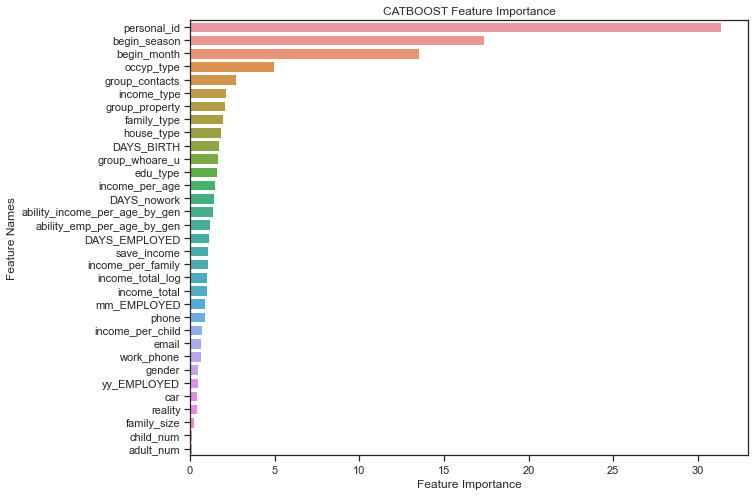

In [497]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

In [498]:
best_submit = submit.copy()
for i in range(3):
    best_submit[str(i)] = (cat_pred_test)[:,i]

In [499]:
best_submit.set_index('index').apply(np.argmax, axis = 1).value_counts()

2    8091
1    1418
0     491
dtype: int64

In [500]:
best_submit.to_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/preprocessing/catboost_renew_save_income.csv', index = False)

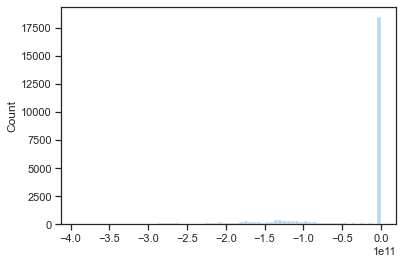

In [419]:
sns.histplot(x = train.income_total_log.apply(np.exp) - train.child_fee_total, data = train[train.child_num > 0])

In [421]:
train.income_total_log.apply(np.exp)

0        202501.0
1        247501.0
2        450001.0
3        202501.0
4        157501.0
           ...   
26446    225001.0
26447    180001.0
26448    292501.0
26449    171001.0
26450     81001.0
Name: income_total_log, Length: 26451, dtype: float64

In [422]:
train.child_fee_total

0        0.000000e+00
1        1.317699e+11
2        0.000000e+00
3        0.000000e+00
4        0.000000e+00
             ...     
26446    2.202007e+11
26447    1.140941e+11
26448    0.000000e+00
26449    0.000000e+00
26450    0.000000e+00
Name: child_fee_total, Length: 26451, dtype: float64

In [350]:
n_fold = 10
seed = 42

def objective(trial):
    skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
    folds=[]
    for train_idx, valid_idx in skfold.split(X, y):
            folds.append((train_idx, valid_idx))
            
    cat_pred = np.zeros((X.shape[0], n_class))
    cat_pred_test = np.zeros((X_test.shape[0], n_class))
    cat_cols = categorical_feats+ ['gender', 'car', 'reality', 'phone', 'email', 'work_phone']

    param = {
        #"objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 1200, 4000, 400),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 6, 12, 2),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "8gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        
    model_folds = []    
    for fold in range(n_fold):
        print(f'\n----------------- Fold {fold+1} -----------------\n')
        train_idx, valid_idx = folds[fold]
        X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
        train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
        valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

        model_cat = CatBoostClassifier(**param)
        model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=200)
        
        model_folds.append(model_cat)
        cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
        cat_pred_test += model_cat.predict_proba(X_test) / n_fold
        print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')

    print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')
    logloss = log_loss(y, cat_pred)
    return logloss

In [351]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30, timeout=6000)

[I 2021-06-17 16:47:55,768] A new study created in memory with name: no-name-13150361-a7d4-4369-a785-4011c721f442
Custom logger is already specified. Specify more than one logger at same time is not thread safe.


----------------- Fold 1 -----------------

0:	learn: 1.0719750	test: 1.0715284	best: 1.0715284 (0)	total: 11.4ms	remaining: 31.9s
200:	learn: 0.7667121	test: 0.7346153	best: 0.7346145 (198)	total: 954ms	remaining: 12.3s
400:	learn: 0.7377638	test: 0.6985819	best: 0.6985478 (396)	total: 1.9s	remaining: 11.4s
600:	learn: 0.7252071	test: 0.6825963	best: 0.6825962 (599)	total: 2.82s	remaining: 10.3s
800:	learn: 0.7171678	test: 0.6731787	best: 0.6731787 (800)	total: 3.8s	remaining: 9.48s
1000:	learn: 0.7124924	test: 0.6690663	best: 0.6690594 (994)	total: 4.75s	remaining: 8.54s
1200:	learn: 0.7076381	test: 0.6644963	best: 0.6644941 (1198)	total: 5.71s	remaining: 7.6s
1400:	learn: 0.7036144	test: 0.6618116	best: 0.6618116 (1397)	total: 6.75s	remaining: 6.74s
1600:	learn: 0.6999179	test: 0.6600589	best: 0.6600589 (1598)	total: 7.86s	remaining: 5.89s
1800:	learn: 0.6969317	test: 0.6595488	best: 0.6595478 (1797)	total: 8.9s	remaining: 4.94s
2000:	learn: 0.6942792	test: 0.6583610	best: 0.658361

0:	learn: 1.0783979	test: 1.0784207	best: 1.0784207 (0)	total: 7.61ms	remaining: 21.3s
200:	learn: 0.7637600	test: 0.7396104	best: 0.7396104 (200)	total: 1s	remaining: 12.9s
400:	learn: 0.7333698	test: 0.6981468	best: 0.6981378 (398)	total: 2s	remaining: 12s
600:	learn: 0.7215694	test: 0.6842578	best: 0.6842361 (582)	total: 2.96s	remaining: 10.8s
800:	learn: 0.7152020	test: 0.6778552	best: 0.6778552 (799)	total: 3.94s	remaining: 9.84s
1000:	learn: 0.7112722	test: 0.6757449	best: 0.6757209 (986)	total: 4.91s	remaining: 8.82s
1200:	learn: 0.7071899	test: 0.6731985	best: 0.6731741 (1199)	total: 5.87s	remaining: 7.82s
1400:	learn: 0.7031685	test: 0.6707910	best: 0.6707910 (1400)	total: 6.9s	remaining: 6.89s
1600:	learn: 0.7000622	test: 0.6696508	best: 0.6696200 (1582)	total: 7.9s	remaining: 5.92s
1800:	learn: 0.6968545	test: 0.6690527	best: 0.6690021 (1792)	total: 8.86s	remaining: 4.92s
2000:	learn: 0.6943392	test: 0.6685474	best: 0.6684875 (1990)	total: 9.82s	remaining: 3.92s
2200:	learn:

[I 2021-06-17 16:50:01,724] Trial 0 finished with value: 0.6693180374883876 and parameters: {'learning_rate': 0.04635497725342579, 'n_estimators': 2800, 'colsample_bylevel': 0.028446117328767603, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.6693180374883876.



----------------- Fold 1 -----------------

0:	learn: 1.0859775	test: 1.0857679	best: 1.0857679 (0)	total: 8.02ms	remaining: 12.8s
200:	learn: 0.8207324	test: 0.8077732	best: 0.8077732 (200)	total: 854ms	remaining: 5.94s
400:	learn: 0.7865180	test: 0.7615739	best: 0.7615739 (400)	total: 1.74s	remaining: 5.21s
600:	learn: 0.7631501	test: 0.7296194	best: 0.7296193 (599)	total: 2.68s	remaining: 4.45s
800:	learn: 0.7501360	test: 0.7123956	best: 0.7123956 (800)	total: 3.67s	remaining: 3.66s
1000:	learn: 0.7394111	test: 0.6975823	best: 0.6975822 (997)	total: 4.61s	remaining: 2.76s
1200:	learn: 0.7323161	test: 0.6885622	best: 0.6885621 (1198)	total: 5.57s	remaining: 1.85s
1400:	learn: 0.7276622	test: 0.6823873	best: 0.6823872 (1397)	total: 6.54s	remaining: 929ms
1599:	learn: 0.7233959	test: 0.6777822	best: 0.6777821 (1597)	total: 7.52s	remaining: 0us

bestTest = 0.6777821049
bestIteration = 1597

Shrink model to first 1598 iterations.
CV Log Loss Score: 0.677782

----------------- Fold 2 ---

1000:	learn: 0.7365041	test: 0.7090624	best: 0.7090624 (1000)	total: 4.67s	remaining: 2.79s
1200:	learn: 0.7304861	test: 0.7012787	best: 0.7012759 (1195)	total: 5.55s	remaining: 1.84s
1400:	learn: 0.7260086	test: 0.6953742	best: 0.6953742 (1400)	total: 6.4s	remaining: 909ms
1599:	learn: 0.7203581	test: 0.6882672	best: 0.6882672 (1599)	total: 7.38s	remaining: 0us

bestTest = 0.6882672326
bestIteration = 1599

CV Log Loss Score: 0.688267

----------------- Fold 10 -----------------

0:	learn: 1.0890260	test: 1.0890236	best: 1.0890236 (0)	total: 7.58ms	remaining: 12.1s
200:	learn: 0.8276835	test: 0.8175924	best: 0.8175924 (200)	total: 895ms	remaining: 6.23s
400:	learn: 0.7925783	test: 0.7753460	best: 0.7753339 (393)	total: 1.74s	remaining: 5.2s
600:	learn: 0.7655465	test: 0.7424198	best: 0.7424198 (599)	total: 2.63s	remaining: 4.37s
800:	learn: 0.7462535	test: 0.7188462	best: 0.7188436 (798)	total: 3.61s	remaining: 3.6s
1000:	learn: 0.7358913	test: 0.7066068	best: 0.7066068 (999)	total: 4

[I 2021-06-17 16:51:21,713] Trial 1 finished with value: 0.688836749032952 and parameters: {'learning_rate': 0.021711359443392465, 'n_estimators': 1600, 'colsample_bylevel': 0.026439583708441586, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6229306906254795}. Best is trial 0 with value: 0.6693180374883876.



----------------- Fold 1 -----------------

0:	learn: 1.0902771	test: 1.0902865	best: 1.0902865 (0)	total: 16.9ms	remaining: 1m 7s
200:	learn: 0.7590139	test: 0.7233567	best: 0.7233567 (200)	total: 5.46s	remaining: 1m 43s
400:	learn: 0.7299497	test: 0.6812588	best: 0.6812577 (398)	total: 10.7s	remaining: 1m 36s
600:	learn: 0.7193760	test: 0.6672243	best: 0.6672243 (600)	total: 16.6s	remaining: 1m 33s
800:	learn: 0.7110620	test: 0.6614379	best: 0.6614379 (800)	total: 24s	remaining: 1m 36s
1000:	learn: 0.7050628	test: 0.6596081	best: 0.6595910 (995)	total: 31.6s	remaining: 1m 34s
1200:	learn: 0.6994671	test: 0.6588554	best: 0.6588554 (1200)	total: 38.9s	remaining: 1m 30s
1400:	learn: 0.6943318	test: 0.6584950	best: 0.6584945 (1399)	total: 46.5s	remaining: 1m 26s
1600:	learn: 0.6891511	test: 0.6581319	best: 0.6581221 (1598)	total: 54.2s	remaining: 1m 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6581069762
bestIteration = 1651

Shrink model to first 1652 iterat

1400:	learn: 0.6928081	test: 0.6737348	best: 0.6737112 (1377)	total: 48.6s	remaining: 1m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6736552089
bestIteration = 1432

Shrink model to first 1433 iterations.
CV Log Loss Score: 0.673655

----------------- Fold 9 -----------------

0:	learn: 1.0902644	test: 1.0902996	best: 1.0902996 (0)	total: 21.4ms	remaining: 1m 25s
200:	learn: 0.7705645	test: 0.7535918	best: 0.7535918 (200)	total: 5.16s	remaining: 1m 37s
400:	learn: 0.7292976	test: 0.6949743	best: 0.6949743 (400)	total: 10.8s	remaining: 1m 36s
600:	learn: 0.7192537	test: 0.6806237	best: 0.6806237 (599)	total: 16.3s	remaining: 1m 32s
800:	learn: 0.7107975	test: 0.6736113	best: 0.6736113 (800)	total: 24.2s	remaining: 1m 36s
1000:	learn: 0.7050496	test: 0.6712126	best: 0.6712126 (1000)	total: 32s	remaining: 1m 35s
1200:	learn: 0.6995678	test: 0.6702880	best: 0.6702695 (1199)	total: 39.8s	remaining: 1m 32s
1400:	learn: 0.6938760	test: 0.6692641	best: 0.6692501 (1

[I 2021-06-17 17:02:11,113] Trial 2 finished with value: 0.6676516012424974 and parameters: {'learning_rate': 0.018845800568165955, 'n_estimators': 4000, 'colsample_bylevel': 0.06138249106981117, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5833610870926725}. Best is trial 2 with value: 0.6676516012424974.



----------------- Fold 1 -----------------

0:	learn: 1.0626585	test: 1.0627002	best: 1.0627002 (0)	total: 3.48ms	remaining: 9.74s
200:	learn: 0.8094793	test: 0.7890382	best: 0.7890381 (199)	total: 675ms	remaining: 8.73s
400:	learn: 0.7749520	test: 0.7437819	best: 0.7437769 (399)	total: 1.37s	remaining: 8.17s
600:	learn: 0.7588390	test: 0.7225128	best: 0.7225092 (590)	total: 2.08s	remaining: 7.63s
800:	learn: 0.7455195	test: 0.7023907	best: 0.7023473 (789)	total: 2.77s	remaining: 6.91s
1000:	learn: 0.7424257	test: 0.6983657	best: 0.6983553 (999)	total: 3.41s	remaining: 6.13s
1200:	learn: 0.7392649	test: 0.6946307	best: 0.6946226 (1198)	total: 4.09s	remaining: 5.45s
1400:	learn: 0.7339386	test: 0.6874294	best: 0.6874294 (1400)	total: 4.78s	remaining: 4.78s
1600:	learn: 0.7309874	test: 0.6842126	best: 0.6842121 (1597)	total: 5.46s	remaining: 4.09s
1800:	learn: 0.7285299	test: 0.6812187	best: 0.6811899 (1787)	total: 6.21s	remaining: 3.45s
2000:	learn: 0.7269096	test: 0.6791526	best: 0.67

1400:	learn: 0.7350307	test: 0.7135239	best: 0.7135239 (1400)	total: 5.57s	remaining: 5.56s
1600:	learn: 0.7309383	test: 0.7083166	best: 0.7083163 (1593)	total: 6.31s	remaining: 4.73s
1800:	learn: 0.7278079	test: 0.7049556	best: 0.7049555 (1797)	total: 7.18s	remaining: 3.98s
2000:	learn: 0.7261562	test: 0.7030436	best: 0.7030217 (1983)	total: 7.97s	remaining: 3.18s
2200:	learn: 0.7243793	test: 0.7013098	best: 0.7012574 (2153)	total: 8.77s	remaining: 2.39s
2400:	learn: 0.7229088	test: 0.7003920	best: 0.7003739 (2372)	total: 9.58s	remaining: 1.59s
2600:	learn: 0.7212499	test: 0.6980324	best: 0.6979942 (2517)	total: 10.4s	remaining: 797ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6979942369
bestIteration = 2517

Shrink model to first 2518 iterations.
CV Log Loss Score: 0.697994

----------------- Fold 7 -----------------

0:	learn: 1.0626658	test: 1.0626693	best: 1.0626693 (0)	total: 4.32ms	remaining: 12.1s
200:	learn: 0.8113804	test: 0.8041874	best: 0.8041874 (

[I 2021-06-17 17:03:53,282] Trial 3 finished with value: 0.685157067019145 and parameters: {'learning_rate': 0.08409498077899194, 'n_estimators': 2800, 'colsample_bylevel': 0.011152083237916863, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.208776545693003}. Best is trial 2 with value: 0.6676516012424974.



----------------- Fold 1 -----------------

0:	learn: 1.0503357	test: 1.0493987	best: 1.0493987 (0)	total: 31.5ms	remaining: 1m 40s
200:	learn: 0.6751230	test: 0.6598191	best: 0.6596480 (195)	total: 4.11s	remaining: 1m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.659071243
bestIteration = 281

Shrink model to first 282 iterations.
CV Log Loss Score: 0.659071

----------------- Fold 2 -----------------

0:	learn: 1.0617892	test: 1.0617972	best: 1.0617972 (0)	total: 7.87ms	remaining: 25.2s
200:	learn: 0.6769069	test: 0.6588182	best: 0.6588182 (200)	total: 4.01s	remaining: 59.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6579751237
bestIteration = 216

Shrink model to first 217 iterations.
CV Log Loss Score: 0.657975

----------------- Fold 3 -----------------

0:	learn: 1.0617860	test: 1.0618001	best: 1.0618001 (0)	total: 7.73ms	remaining: 24.7s
200:	learn: 0.6788005	test: 0.6647181	best: 0.6647181 (200)	total: 3.76s	remaining: 56.2s


[I 2021-06-17 17:05:19,495] Trial 4 finished with value: 0.6694335860492017 and parameters: {'learning_rate': 0.0862607106939922, 'n_estimators': 3200, 'colsample_bylevel': 0.09943932782671508, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5799013811719267}. Best is trial 2 with value: 0.6676516012424974.



----------------- Fold 1 -----------------

0:	learn: 1.0644403	test: 1.0644798	best: 1.0644798 (0)	total: 15.4ms	remaining: 18.4s
200:	learn: 0.8026282	test: 0.7822718	best: 0.7822603 (193)	total: 3.3s	remaining: 16.4s
400:	learn: 0.7584133	test: 0.7250464	best: 0.7250464 (400)	total: 6.8s	remaining: 13.5s
600:	learn: 0.7380169	test: 0.6962386	best: 0.6962351 (595)	total: 10.3s	remaining: 10.3s
800:	learn: 0.7265969	test: 0.6813166	best: 0.6812459 (799)	total: 13.9s	remaining: 6.92s
1000:	learn: 0.7207453	test: 0.6755421	best: 0.6754648 (978)	total: 17.4s	remaining: 3.45s
1199:	learn: 0.7160265	test: 0.6715756	best: 0.6715582 (1191)	total: 21.1s	remaining: 0us

bestTest = 0.6715581871
bestIteration = 1191

Shrink model to first 1192 iterations.
CV Log Loss Score: 0.671558

----------------- Fold 2 -----------------

0:	learn: 1.0644302	test: 1.0645276	best: 1.0645276 (0)	total: 16ms	remaining: 19.2s
200:	learn: 0.7852833	test: 0.7681132	best: 0.7681130 (198)	total: 3.27s	remaining: 1

[I 2021-06-17 17:09:01,461] Trial 5 finished with value: 0.6771563232617144 and parameters: {'learning_rate': 0.07974271617342324, 'n_estimators': 1200, 'colsample_bylevel': 0.019786064624049304, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3052393426579132}. Best is trial 2 with value: 0.6676516012424974.



----------------- Fold 1 -----------------

0:	learn: 1.0602466	test: 1.0595974	best: 1.0595974 (0)	total: 19.5ms	remaining: 1m 10s
200:	learn: 0.7543226	test: 0.7181530	best: 0.7181530 (200)	total: 4.34s	remaining: 1m 13s
400:	learn: 0.7301984	test: 0.6855305	best: 0.6855299 (396)	total: 8.82s	remaining: 1m 10s
600:	learn: 0.7200878	test: 0.6740504	best: 0.6740282 (597)	total: 12.9s	remaining: 1m 4s
800:	learn: 0.7153905	test: 0.6697147	best: 0.6696631 (790)	total: 17.7s	remaining: 1m 1s
1000:	learn: 0.7124041	test: 0.6670455	best: 0.6670346 (997)	total: 22.4s	remaining: 58.3s
1200:	learn: 0.7090208	test: 0.6646913	best: 0.6646912 (1196)	total: 27s	remaining: 53.9s
1400:	learn: 0.7061540	test: 0.6639508	best: 0.6639345 (1394)	total: 31.1s	remaining: 48.8s
1600:	learn: 0.7033772	test: 0.6633491	best: 0.6632659 (1558)	total: 35.2s	remaining: 43.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6632658839
bestIteration = 1558

Shrink model to first 1559 iterations.

CV Log Loss Score: 0.667725

----------------- Fold 8 -----------------

0:	learn: 1.0695037	test: 1.0694904	best: 1.0694904 (0)	total: 18.6ms	remaining: 1m 6s
200:	learn: 0.7736452	test: 0.7551782	best: 0.7551780 (194)	total: 3.73s	remaining: 1m 3s
400:	learn: 0.7327290	test: 0.7050518	best: 0.7050518 (398)	total: 8.97s	remaining: 1m 11s
600:	learn: 0.7234681	test: 0.6931658	best: 0.6931590 (599)	total: 13.5s	remaining: 1m 7s
800:	learn: 0.7153887	test: 0.6844896	best: 0.6844665 (799)	total: 18.3s	remaining: 1m 3s
1000:	learn: 0.7120070	test: 0.6826172	best: 0.6826030 (994)	total: 22.7s	remaining: 59s
1200:	learn: 0.7090353	test: 0.6803957	best: 0.6803812 (1181)	total: 26.8s	remaining: 53.6s
1400:	learn: 0.7050622	test: 0.6784500	best: 0.6784500 (1400)	total: 33.7s	remaining: 52.9s
1600:	learn: 0.7013740	test: 0.6775920	best: 0.6775357 (1588)	total: 38.6s	remaining: 48.2s
1800:	learn: 0.6983195	test: 0.6769825	best: 0.6767932 (1755)	total: 43.3s	remaining: 43.2s
2000:	learn: 0.6951715

[I 2021-06-17 17:17:05,112] Trial 6 finished with value: 0.6716959798218833 and parameters: {'learning_rate': 0.06750702000488477, 'n_estimators': 3600, 'colsample_bylevel': 0.022977400541708173, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.409209197355975}. Best is trial 2 with value: 0.6676516012424974.



----------------- Fold 1 -----------------

0:	learn: 1.0847751	test: 1.0847907	best: 1.0847907 (0)	total: 20ms	remaining: 40.1s
200:	learn: 0.7310964	test: 0.6817893	best: 0.6817893 (200)	total: 7.57s	remaining: 1m 7s
400:	learn: 0.7126887	test: 0.6599589	best: 0.6599589 (400)	total: 16s	remaining: 1m 3s
600:	learn: 0.7011824	test: 0.6570748	best: 0.6570748 (600)	total: 27.6s	remaining: 1m 4s
800:	learn: 0.6900215	test: 0.6559083	best: 0.6558794 (786)	total: 39.3s	remaining: 58.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6555997446
bestIteration = 865

Shrink model to first 866 iterations.
CV Log Loss Score: 0.655600

----------------- Fold 2 -----------------

0:	learn: 1.0804012	test: 1.0805443	best: 1.0805443 (0)	total: 52.9ms	remaining: 1m 45s
200:	learn: 0.7293687	test: 0.6773829	best: 0.6773829 (200)	total: 7.24s	remaining: 1m 4s
400:	learn: 0.7143858	test: 0.6579830	best: 0.6579711 (399)	total: 15s	remaining: 59.6s
600:	learn: 0.7029575	test: 0.6551

[I 2021-06-17 17:25:58,431] Trial 7 finished with value: 0.6666297448976278 and parameters: {'learning_rate': 0.03148804286737452, 'n_estimators': 2000, 'colsample_bylevel': 0.08550203288540487, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7777311966683135}. Best is trial 7 with value: 0.6666297448976278.



----------------- Fold 1 -----------------

0:	learn: 1.0767257	test: 1.0767506	best: 1.0767506 (0)	total: 15ms	remaining: 54.1s
200:	learn: 0.7203198	test: 0.6673557	best: 0.6673535 (199)	total: 7.54s	remaining: 2m 7s
400:	learn: 0.6996682	test: 0.6588026	best: 0.6587897 (399)	total: 17.8s	remaining: 2m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6579493263
bestIteration = 460

Shrink model to first 461 iterations.
CV Log Loss Score: 0.657949

----------------- Fold 2 -----------------

0:	learn: 1.0698041	test: 1.0700329	best: 1.0700329 (0)	total: 60.8ms	remaining: 3m 38s
200:	learn: 0.7202589	test: 0.6650453	best: 0.6650453 (200)	total: 7.14s	remaining: 2m
400:	learn: 0.6994214	test: 0.6571617	best: 0.6571352 (399)	total: 17.6s	remaining: 2m 20s
600:	learn: 0.6824713	test: 0.6565818	best: 0.6565818 (600)	total: 28.8s	remaining: 2m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6565817977
bestIteration = 600

Shrink model to fir

[I 2021-06-17 17:31:45,675] Trial 8 finished with value: 0.6684161101145222 and parameters: {'learning_rate': 0.050290469207485894, 'n_estimators': 3600, 'colsample_bylevel': 0.0844832461445846, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.46409744364223526}. Best is trial 7 with value: 0.6666297448976278.



----------------- Fold 1 -----------------

0:	learn: 1.0902973	test: 1.0903066	best: 1.0903066 (0)	total: 4.03ms	remaining: 14.5s
200:	learn: 0.7603849	test: 0.7274805	best: 0.7274805 (200)	total: 1.97s	remaining: 33.3s
400:	learn: 0.7275197	test: 0.6875233	best: 0.6875233 (399)	total: 4.17s	remaining: 33.3s
600:	learn: 0.7099885	test: 0.6729364	best: 0.6729364 (600)	total: 6.61s	remaining: 33s
800:	learn: 0.6947885	test: 0.6667431	best: 0.6667431 (800)	total: 9.18s	remaining: 32.1s
1000:	learn: 0.6835457	test: 0.6638972	best: 0.6638972 (1000)	total: 11.5s	remaining: 29.7s
1200:	learn: 0.6719056	test: 0.6625263	best: 0.6625263 (1200)	total: 13.9s	remaining: 27.7s
1400:	learn: 0.6616091	test: 0.6615561	best: 0.6614426 (1373)	total: 16.3s	remaining: 25.5s
1600:	learn: 0.6510686	test: 0.6612267	best: 0.6611365 (1584)	total: 18.7s	remaining: 23.4s
1800:	learn: 0.6414221	test: 0.6609736	best: 0.6608808 (1743)	total: 21.3s	remaining: 21.3s
2000:	learn: 0.6311318	test: 0.6606162	best: 0.660

0:	learn: 1.0902783	test: 1.0902973	best: 1.0902973 (0)	total: 8.47ms	remaining: 30.5s
200:	learn: 0.7669556	test: 0.7502236	best: 0.7502236 (200)	total: 2.04s	remaining: 34.6s
400:	learn: 0.7309025	test: 0.7078239	best: 0.7078239 (399)	total: 4.16s	remaining: 33.2s
600:	learn: 0.7095422	test: 0.6895300	best: 0.6895300 (600)	total: 6.7s	remaining: 33.4s
800:	learn: 0.6935370	test: 0.6830215	best: 0.6830215 (800)	total: 9.42s	remaining: 32.9s
1000:	learn: 0.6801295	test: 0.6801575	best: 0.6801575 (1000)	total: 12.1s	remaining: 31.4s
1200:	learn: 0.6685944	test: 0.6786046	best: 0.6786046 (1200)	total: 14.4s	remaining: 28.9s
1400:	learn: 0.6568918	test: 0.6776909	best: 0.6776909 (1400)	total: 16.9s	remaining: 26.5s
1600:	learn: 0.6453588	test: 0.6770653	best: 0.6770460 (1598)	total: 19.4s	remaining: 24.2s
1800:	learn: 0.6350211	test: 0.6763091	best: 0.6762586 (1789)	total: 21.9s	remaining: 21.9s
2000:	learn: 0.6261493	test: 0.6758481	best: 0.6757802 (1964)	total: 24.2s	remaining: 19.3s
St

[I 2021-06-17 17:35:52,666] Trial 9 finished with value: 0.6713441740930074 and parameters: {'learning_rate': 0.01879975474282336, 'n_estimators': 3600, 'colsample_bylevel': 0.058799289840164824, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.1150875401585643}. Best is trial 7 with value: 0.6666297448976278.



----------------- Fold 1 -----------------

0:	learn: 1.0759904	test: 1.0745908	best: 1.0745908 (0)	total: 31.6ms	remaining: 1m 3s
200:	learn: 0.7152116	test: 0.6686046	best: 0.6686046 (200)	total: 41.1s	remaining: 6m 8s
400:	learn: 0.6856332	test: 0.6630142	best: 0.6630142 (400)	total: 1m 49s	remaining: 7m 14s
600:	learn: 0.6389885	test: 0.6614979	best: 0.6614769 (599)	total: 3m 43s	remaining: 8m 40s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6612741983
bestIteration = 613

Shrink model to first 614 iterations.
CV Log Loss Score: 0.661274

----------------- Fold 2 -----------------

0:	learn: 1.0808764	test: 1.0809218	best: 1.0809218 (0)	total: 19.4ms	remaining: 38.8s
200:	learn: 0.7171579	test: 0.6695147	best: 0.6695136 (198)	total: 35.9s	remaining: 5m 21s
400:	learn: 0.6796839	test: 0.6614321	best: 0.6614321 (400)	total: 1m 52s	remaining: 7m 28s
600:	learn: 0.6339218	test: 0.6591292	best: 0.6590371 (587)	total: 3m 44s	remaining: 8m 42s
Stopped by overfitti

[I 2021-06-17 18:20:25,659] Trial 10 finished with value: 0.6705858303823019 and parameters: {'learning_rate': 0.040529377556869105, 'n_estimators': 2000, 'colsample_bylevel': 0.08335704164788042, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 7 with value: 0.6666297448976278.



----------------- Fold 1 -----------------

0:	learn: 1.0936863	test: 1.0936918	best: 1.0936918 (0)	total: 19ms	remaining: 38.1s
200:	learn: 0.8011006	test: 0.7823063	best: 0.7823063 (200)	total: 7.82s	remaining: 1m 10s
400:	learn: 0.7582655	test: 0.7226973	best: 0.7226973 (400)	total: 14.7s	remaining: 58.6s
600:	learn: 0.7375857	test: 0.6930581	best: 0.6930581 (600)	total: 22.4s	remaining: 52.2s
800:	learn: 0.7256405	test: 0.6756428	best: 0.6756427 (798)	total: 32.3s	remaining: 48.3s
1000:	learn: 0.7198121	test: 0.6679512	best: 0.6679512 (1000)	total: 40.7s	remaining: 40.6s
1200:	learn: 0.7148531	test: 0.6628682	best: 0.6628682 (1200)	total: 52.4s	remaining: 34.9s
1400:	learn: 0.7099760	test: 0.6602557	best: 0.6602557 (1400)	total: 1m 10s	remaining: 29.9s
1600:	learn: 0.7060579	test: 0.6589713	best: 0.6589713 (1600)	total: 1m 26s	remaining: 21.5s
1800:	learn: 0.7026776	test: 0.6583699	best: 0.6583666 (1799)	total: 1m 42s	remaining: 11.3s
1999:	learn: 0.6987245	test: 0.6575042	best: 0

600:	learn: 0.7364886	test: 0.7077112	best: 0.7077112 (600)	total: 22.6s	remaining: 52.7s
800:	learn: 0.7238688	test: 0.6906513	best: 0.6906513 (800)	total: 32s	remaining: 47.9s
1000:	learn: 0.7177543	test: 0.6830158	best: 0.6830158 (1000)	total: 40.1s	remaining: 40.1s
1200:	learn: 0.7128119	test: 0.6784535	best: 0.6784535 (1200)	total: 52s	remaining: 34.6s
1400:	learn: 0.7078601	test: 0.6757963	best: 0.6757963 (1400)	total: 1m 10s	remaining: 30s
1600:	learn: 0.7039733	test: 0.6746721	best: 0.6746615 (1597)	total: 1m 27s	remaining: 21.8s
1800:	learn: 0.7004163	test: 0.6740242	best: 0.6740202 (1799)	total: 1m 43s	remaining: 11.5s
1999:	learn: 0.6963246	test: 0.6734948	best: 0.6734948 (1999)	total: 2m 3s	remaining: 0us

bestTest = 0.67349485
bestIteration = 1999

CV Log Loss Score: 0.673495

----------------- Fold 9 -----------------

0:	learn: 1.0936788	test: 1.0936995	best: 1.0936995 (0)	total: 21.9ms	remaining: 43.8s
200:	learn: 0.8034222	test: 0.7912412	best: 0.7912412 (200)	total: 6

[I 2021-06-17 18:40:42,294] Trial 11 finished with value: 0.6679547464488006 and parameters: {'learning_rate': 0.011094214686002694, 'n_estimators': 2000, 'colsample_bylevel': 0.05634563465934163, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9189877277551838}. Best is trial 7 with value: 0.6666297448976278.


In [352]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 12
Best trial:
  Value: 0.6666297448976278
  Params: 
    learning_rate: 0.03148804286737452
    n_estimators: 2000
    colsample_bylevel: 0.08550203288540487
    depth: 8
    boosting_type: Ordered
    bootstrap_type: Bernoulli
    subsample: 0.7777311966683135


In [353]:
trial.params

{'learning_rate': 0.03148804286737452,
 'n_estimators': 2000,
 'colsample_bylevel': 0.08550203288540487,
 'depth': 8,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.7777311966683135}

In [355]:
skfold = StratifiedKFold(n_splits=15, shuffle=True, random_state=55)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = categorical_feats
print('category features : {}'.format(cat_cols))
model_folds = [] 
# 15Fold-CV (StratifiedKFold)
for fold in range(len(folds)):
    print(f'\n----------------- Fold {fold+1} -----------------\n')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y.iloc[train_idx], y.iloc[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

    model_cat = CatBoostClassifier(**trial.params)
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=50, verbose=100)
    model_folds.append(model_cat)

    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / len(folds)
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')

category features : ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'personal_id', 'group_property', 'group_contacts', 'group_whoare_u']

----------------- Fold 1 -----------------

0:	learn: 1.0806170	test: 1.0806682	best: 1.0806682 (0)	total: 57.7ms	remaining: 1m 55s


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

100:	learn: 0.7627445	test: 0.7495138	best: 0.7495138 (100)	total: 2.79s	remaining: 52.4s
200:	learn: 0.7254274	test: 0.6962753	best: 0.6962753 (200)	total: 6.02s	remaining: 53.9s
300:	learn: 0.7162122	test: 0.6825340	best: 0.6825340 (300)	total: 9.41s	remaining: 53.1s
400:	learn: 0.7101788	test: 0.6758263	best: 0.6758263 (400)	total: 13.1s	remaining: 52.4s
500:	learn: 0.7044683	test: 0.6735712	best: 0.6735051 (492)	total: 18.2s	remaining: 54.4s
600:	learn: 0.6997974	test: 0.6723796	best: 0.6723796 (600)	total: 23.1s	remaining: 53.8s
700:	learn: 0.6948198	test: 0.6713737	best: 0.6713737 (700)	total: 28.1s	remaining: 52s
800:	learn: 0.6897517	test: 0.6709966	best: 0.6709358 (799)	total: 33.3s	remaining: 49.9s
900:	learn: 0.6850216	test: 0.6702976	best: 0.6702422 (875)	total: 38.3s	remaining: 46.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6702422071
bestIteration = 875

Shrink model to first 876 iterations.
CV Log Loss Score: 0.670242

----------------- Fold 2 

0:	learn: 1.0847499	test: 1.0846703	best: 1.0846703 (0)	total: 22.3ms	remaining: 44.5s
100:	learn: 0.7576027	test: 0.7352514	best: 0.7352514 (100)	total: 3.33s	remaining: 1m 2s
200:	learn: 0.7272483	test: 0.6915637	best: 0.6915637 (200)	total: 6.41s	remaining: 57.3s
300:	learn: 0.7173648	test: 0.6759434	best: 0.6759434 (300)	total: 9.88s	remaining: 55.8s
400:	learn: 0.7107114	test: 0.6695557	best: 0.6695557 (400)	total: 14s	remaining: 55.7s
500:	learn: 0.7047929	test: 0.6671332	best: 0.6671332 (500)	total: 19.1s	remaining: 57.2s
600:	learn: 0.6990090	test: 0.6654321	best: 0.6653637 (584)	total: 24.4s	remaining: 56.9s
700:	learn: 0.6930584	test: 0.6643307	best: 0.6643307 (700)	total: 29.6s	remaining: 54.9s
800:	learn: 0.6881252	test: 0.6632413	best: 0.6632351 (797)	total: 34.8s	remaining: 52.1s
900:	learn: 0.6829231	test: 0.6627751	best: 0.6627706 (899)	total: 39.6s	remaining: 48.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6626651358
bestIteration = 927

Shrin

In [378]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(12, 8))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('CATBOOST Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

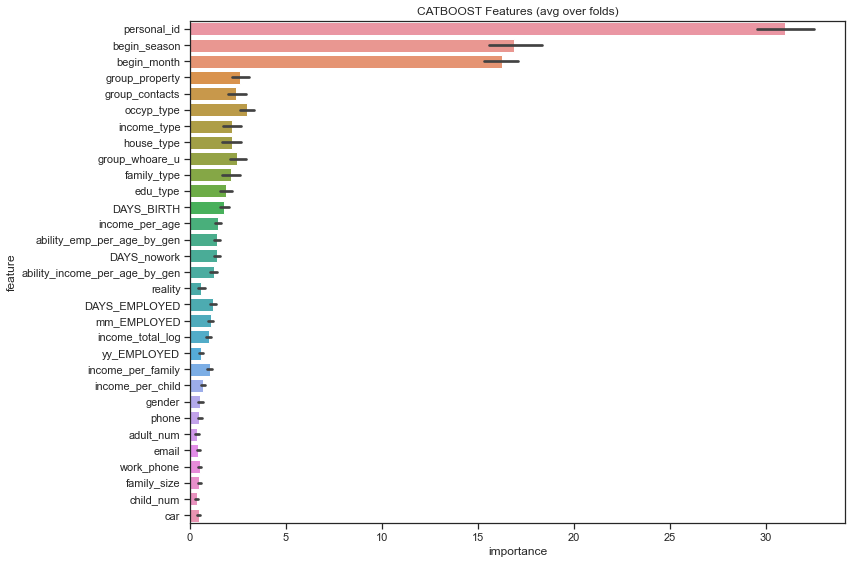

In [379]:
feats = X.columns
feature_importance_df = pd.DataFrame()
n = len(model_folds)
for i in range(n):
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = model_folds[i].feature_importances_
    fold_importance_df["fold"] = i
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
display_importances(feature_importance_df)

In [356]:
for i in range(3):
    submit[str(i)] = (cat_pred_test)[:,i]

In [357]:
submit.set_index('index').apply(np.argmax, axis = 1).value_counts()

2    8099
1    1417
0     484
dtype: int64

In [358]:
submit.to_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/preprocessing/catboost_renew+optuna.csv', index = False)